In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv('merge_train.csv',parse_dates=['date'])

In [3]:
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekdays'] = df['date'].dt.dayofweek  # 1 for weekend, 0 for weekday
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
# df['EMA_4h'] = df['Price'].ewm(span=48, adjust=False).mean()


df['SMA_4h'] = df['Price'].shift(1).rolling(window=48).mean()
# df['EMA_1d'] = df['Price'].ewm(span=288, adjust=False).mean()
df['Forecast_difference_0.5 hour future'] = df['Forecast_Roof_0.5 hour future'] - df['Forecast_Demand_0.5 hour future']
df["Forecast_ratio_0.5 hour future"] = df['Forecast_Roof_0.5 hour future'] / df['Forecast_Demand_0.5 hour future']
df.set_index('date', inplace=True)

In [4]:

df = df.drop(columns=['Region', 'Actual_Roof_OPOWER', 'Actual_Roof_LASTCHANGED'])


In [5]:
from datetime import datetime, time

def create_qld_holidays_list():
    holidays = [
        # 2023
        "2023-01-01", "2023-01-02", "2023-01-26", "2023-04-07", "2023-04-08", "2023-04-09", "2023-04-10",
        "2023-04-25", "2023-05-01", "2023-08-16", "2023-10-02", "2023-12-25", "2023-12-26",
        # 2024
        "2024-01-01", "2024-01-26", "2024-03-29", "2024-03-30", "2024-03-31", "2024-04-01",
        "2024-04-25", "2024-05-06", "2024-08-14", "2024-10-07", "2024-12-25", "2024-12-26",
        # 2025
        "2025-01-01", "2025-01-27", "2025-04-18", "2025-04-19", "2025-04-20", "2025-04-21",
        "2025-04-25", "2025-05-05", "2025-08-13", "2025-10-06", "2025-12-25", "2025-12-26"
    ]
    return pd.to_datetime(holidays)

def add_qld_holidays(df):
    holidays = create_qld_holidays_list()
    
   
    df['is_holiday'] = 0
    
    df.loc[df.index.isin(holidays), 'is_holiday'] = 1
    
    
    return df

In [6]:
df = add_qld_holidays(df)

In [7]:
for feature in df.columns:
    
    df[f'{feature}_shift_1'] = df[feature].shift(1)
    df[f'{feature}_shift_2'] = df[feature].shift(2)
    df[f'{feature}_shift_3'] = df[feature].shift(3)
    df[f'{feature}_shift_4'] = df[feature].shift(4)
    df[f'{feature}_shift_5'] = df[feature].shift(5)
    df[f'{feature}_shift_6'] = df[feature].shift(6)
df = df.dropna()

C:\Users\Owner\AppData\Local\Temp\ipykernel_8280\1034345637.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_shift_5'] = df[feature].shift(5)
C:\Users\Owner\AppData\Local\Temp\ipykernel_8280\1034345637.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{feature}_shift_6'] = df[feature].shift(6)
C:\Users\Owner\AppData\Local\Temp\ipykernel_8280\1034345637.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  C

In [8]:
X = df.drop('Price', axis=1)
y = df['Price']

train_end_date = pd.to_datetime("2024-04-30 23:59:59")
val_end_date = pd.to_datetime("2024-05-31 23:59:59")
test_start_date = pd.to_datetime("2024-06-01 00:00:00")


X_train = X[X.index <= train_end_date]
X_val = X[(X.index > train_end_date) & (X.index <= val_end_date)]
X_test = X[X.index >= test_start_date]

y_train = y[y.index <= train_end_date]
y_val = y[(y.index > train_end_date) & (y.index <= val_end_date)]
y_test = y[y.index >= test_start_date]

In [9]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
class MultiLossXGBoostElectricityPrice:
    def __init__(self, alpha: float = 0.5, beta: float = 0.3, gamma: float = 0.2, forecast_horizon=12 ):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.forecast_horizon = forecast_horizon
        self.models = []

    def custom_objective(self, preds: np.ndarray, dtrain: xgb.DMatrix):
        labels = dtrain.get_label()
        
        # MSE gradient and hessian
        grad_mse = preds - labels
        hess_mse = np.ones_like(preds)
        
        # MAE gradient and hessian
        grad_mae = np.sign(preds - labels)
        hess_mae = np.ones_like(preds) * 1e-6
        
        # Huber loss gradient and hessian (delta = 1)
        delta = 1
        diff = preds - labels
        grad_huber = np.where(np.abs(diff) <= delta, diff, delta * np.sign(diff))
        hess_huber = np.where(np.abs(diff) <= delta, 1, 0)
        
        # Combine gradients and hessians
        grad = self.alpha * grad_mse + self.beta * grad_mae + self.gamma * grad_huber
        hess = self.alpha * hess_mse + self.beta * hess_mae + self.gamma * hess_huber
        
        return grad, hess

    def custom_metric(self, preds: np.ndarray, dtrain: xgb.DMatrix):
        labels = dtrain.get_label()
        
        mse = mean_squared_error(labels, preds)
        mae = mean_absolute_error(labels, preds)
        huber = np.mean(np.where(np.abs(preds - labels) <= 5, 
                                 0.5 * (preds - labels)**2, 
                                 np.abs(preds - labels) - 0.5))
        
        combined_metric = self.alpha * mse + self.beta * mae + self.gamma * huber
        
        return 'combined_metric', combined_metric

    def prepare_multistep_data(self, X: pd.DataFrame, y: pd.Series):
        data = []
        for i in range(1, self.forecast_horizon + 1):
            y_shifted = y.shift(-i).dropna()# move forwrad by i steps
            X_trimmed = X.iloc[:len(y_shifted)]
            data.append((X_trimmed, y_shifted))
        return data

    def train(self, X_train: pd.DataFrame, y_train: pd.Series, X_val: pd.DataFrame, y_val: pd.Series):
        train_data = self.prepare_multistep_data(X_train, y_train)
        val_data = self.prepare_multistep_data(X_val, y_val)

        for step in range(self.forecast_horizon):
            print(f"Training model for step {step + 1}")
            X_train_step, y_train_step = train_data[step]
            X_val_step, y_val_step = val_data[step]

            dtrain = xgb.DMatrix(X_train_step, label=y_train_step)
            dval = xgb.DMatrix(X_val_step, label=y_val_step)

            params = {
                # 'objective': 'reg:squarederror',
                'max_depth': 11,
                'learning_rate': 0.03,
                'min_child_weight': 0.8,
                "lambda": 0.9,
                'random_state': 42
            }

            model = xgb.train(
                params,
                dtrain,
                num_boost_round=1000,
                evals=[(dtrain, 'train'), (dval, 'val')],
                obj=self.custom_objective,
                custom_metric=self.custom_metric,
                early_stopping_rounds=100,
                verbose_eval=100
            )

            self.models.append(model)

    def predict(self, X: pd.DataFrame):
        forecasts = np.zeros((len(X), self.forecast_horizon))
        for step, model in enumerate(self.models):
            dtest = xgb.DMatrix(X)
            forecasts[:, step] = model.predict(dtest)
        return forecasts

In [10]:

model = MultiLossXGBoostElectricityPrice(alpha=0.4, beta=0.4, gamma=0.2,forecast_horizon=12)
model.train(X_train, y_train, X_val, y_val)


Training model for step 1
[0]	train-rmse:401.24894	train-combined_metric:64454.42169	val-rmse:122.34964	val-combined_metric:6047.40715
[100]	train-rmse:98.47850	train-combined_metric:3889.04259	val-rmse:46.12673	val-combined_metric:864.09196
[175]	train-rmse:51.87429	train-combined_metric:1084.65401	val-rmse:47.97101	val-combined_metric:933.00512
Training model for step 2
[0]	train-rmse:400.84082	train-combined_metric:64323.49975	val-rmse:122.40515	val-combined_metric:6052.84758
[100]	train-rmse:101.98407	train-combined_metric:4170.79572	val-rmse:60.61700	val-combined_metric:1484.22429
[167]	train-rmse:60.20684	train-combined_metric:1459.05573	val-rmse:68.41393	val-combined_metric:1886.28566
Training model for step 3
[0]	train-rmse:401.36675	train-combined_metric:64492.26001	val-rmse:122.56521	val-combined_metric:6068.59936
[100]	train-rmse:104.25698	train-combined_metric:4358.71690	val-rmse:51.04985	val-combined_metric:1058.00599
[166]	train-rmse:61.52830	train-combined_metric:1523.75

In [11]:
# dtest = xgb.DMatrix(X_test)
y_pred = model.predict(X_test)

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import HourLocator, DateFormatter
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_and_plot_forecast(y_true, y_pred, step=12, days_to_plot=3):
    """
    Evaluate and plot the results for a specific forecast step
    
    :param y_true: Actual values, pandas Series
    :param y_pred: Predicted values, numpy array with shape (n_samples, n_steps)
    :param step: Forecast step to evaluate, default is 12
    :param days_to_plot: Number of days to plot in each graph, default is 3
    """
    # Ensure the step is valid
    if step < 1 or step > y_pred.shape[1]:
        raise ValueError(f"Step should be between 1 and {y_pred.shape[1]}")
    
    # Create results DataFrame
    results_df = pd.DataFrame({
        'Actual': y_true.iloc[step-1:],
        'Predicted': y_pred[:-step+1, step-1]
    }, index=y_true.index[step-1:])
    
    # Calculate overall metrics
    mse = mean_squared_error(results_df['Actual'], results_df['Predicted'])
    mae = mean_absolute_error(results_df['Actual'], results_df['Predicted'])
    rmse = np.sqrt(mse)
    r2 = r2_score(results_df['Actual'], results_df['Predicted'])
    
    print(f"Overall Performance Metrics for Step {step}:")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"Root Mean Squared Error: {rmse:.4f}")
    print(f"R-squared Score: {r2:.4f}")
    
    # Plot the results
    start_date = results_df.index.min()
    end_date = results_df.index.max()
    current_date = start_date
    
    while current_date <= end_date:
        period_end = min(current_date + pd.Timedelta(days=days_to_plot), end_date)
        plot_comparison(results_df, current_date, period_end, step)
        current_date += pd.Timedelta(days=days_to_plot)

def plot_comparison(data, start_date, end_date, step):
    """
    Plot a comparison of actual vs predicted prices for a specific period
    
    :param data: DataFrame containing 'Actual' and 'Predicted' columns
    :param start_date: Start date of the period to plot
    :param end_date: End date of the period to plot
    :param step: Forecast step being evaluated
    """
    period_data = data.loc[start_date:end_date]
    
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(period_data.index, period_data['Actual'], label='Actual', marker='o', markersize=4)
    ax.plot(period_data.index, period_data['Predicted'], label=f'Predicted (Step {step})', marker='o', markersize=4)
    
    ax.set_title(f'Actual vs Predicted Prices - Step {step}\n({start_date.strftime("%Y-%m-%d %H:%M")} to {end_date.strftime("%Y-%m-%d %H:%M")})')
    ax.set_xlabel('Date and Time')
    ax.set_ylabel('Price')
    ax.legend()
    
    # Set x-axis ticks to show every 6 hours
    ax.xaxis.set_major_locator(HourLocator(interval=6))
    ax.xaxis.set_major_formatter(DateFormatter('%m-%d %H:%M'))
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Calculate and display metrics for the current period
    mse = mean_squared_error(period_data['Actual'], period_data['Predicted'])
    mae = mean_absolute_error(period_data['Actual'], period_data['Predicted'])
    rmse = np.sqrt(mse)
    r2 = r2_score(period_data['Actual'], period_data['Predicted'])
    
    metrics_text = f'MSE: {mse:.4f}\nMAE: {mae:.4f}\nRMSE: {rmse:.4f}\nR²: {r2:.4f}'
    plt.text(0.02, 0.98, metrics_text, transform=ax.transAxes, verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.show()

# Usage example
# Assuming y_test is the actual values and future_forecasts is your model's predictions
# evaluate_and_plot_forecast(y_test, future_forecasts, step=12, days_to_plot=3)

Overall Performance Metrics for Step 12:
Mean Squared Error: 64703.2846
Mean Absolute Error: 53.8635
Root Mean Squared Error: 254.3684
R-squared Score: 0.0450


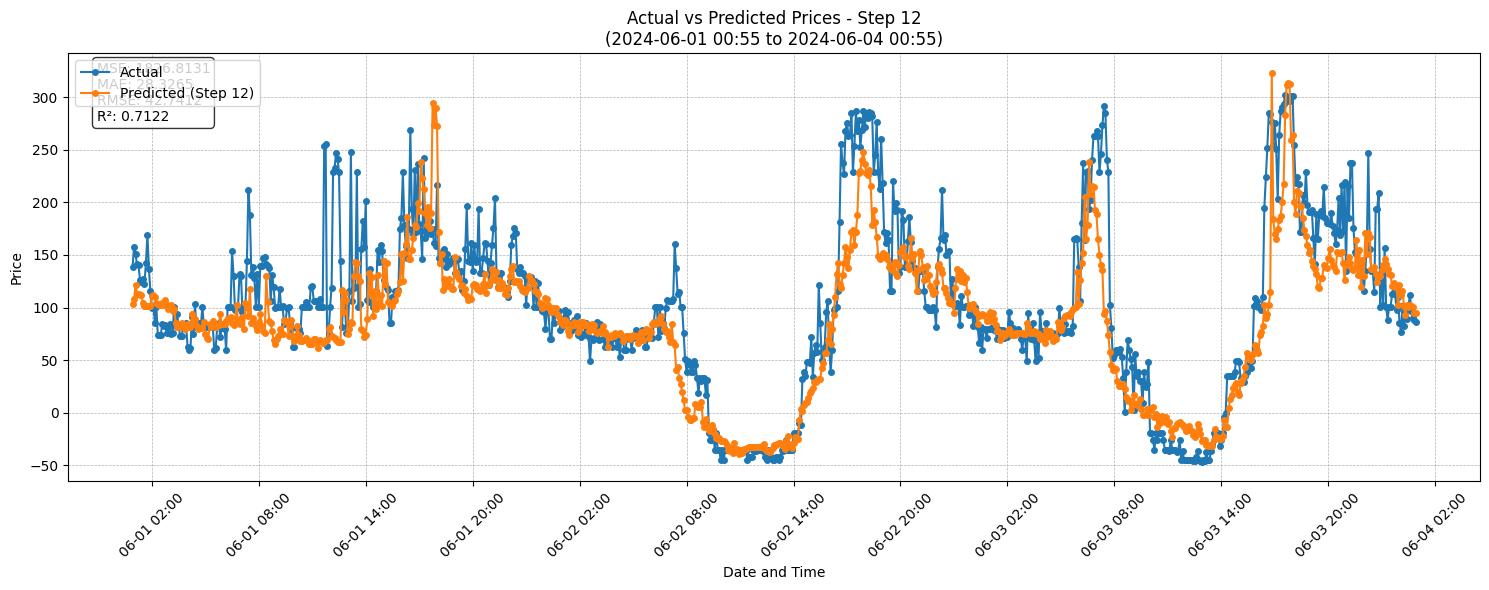

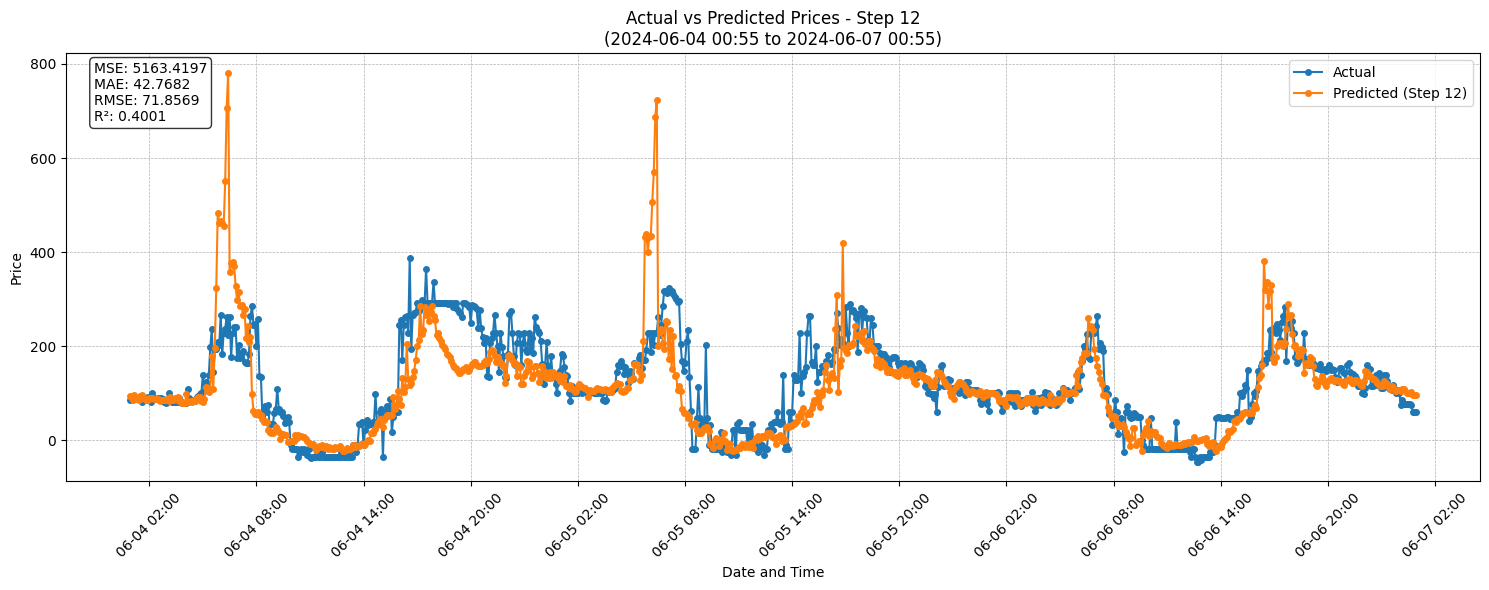

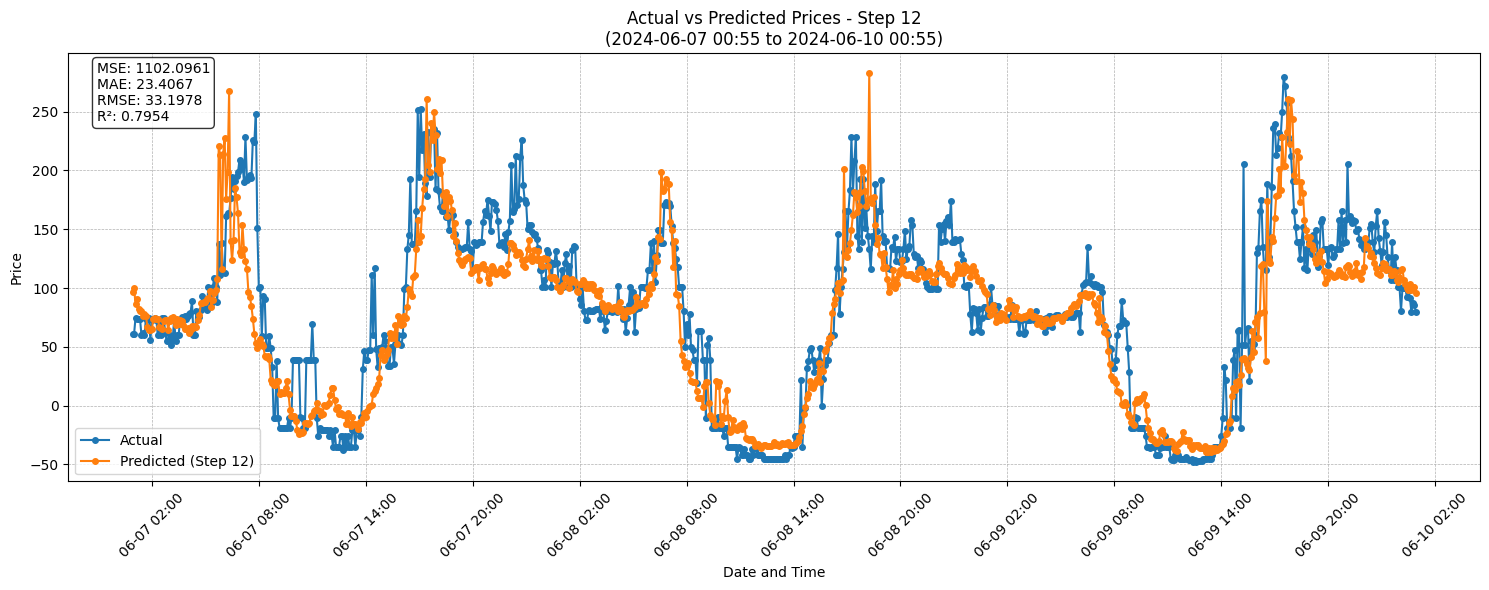

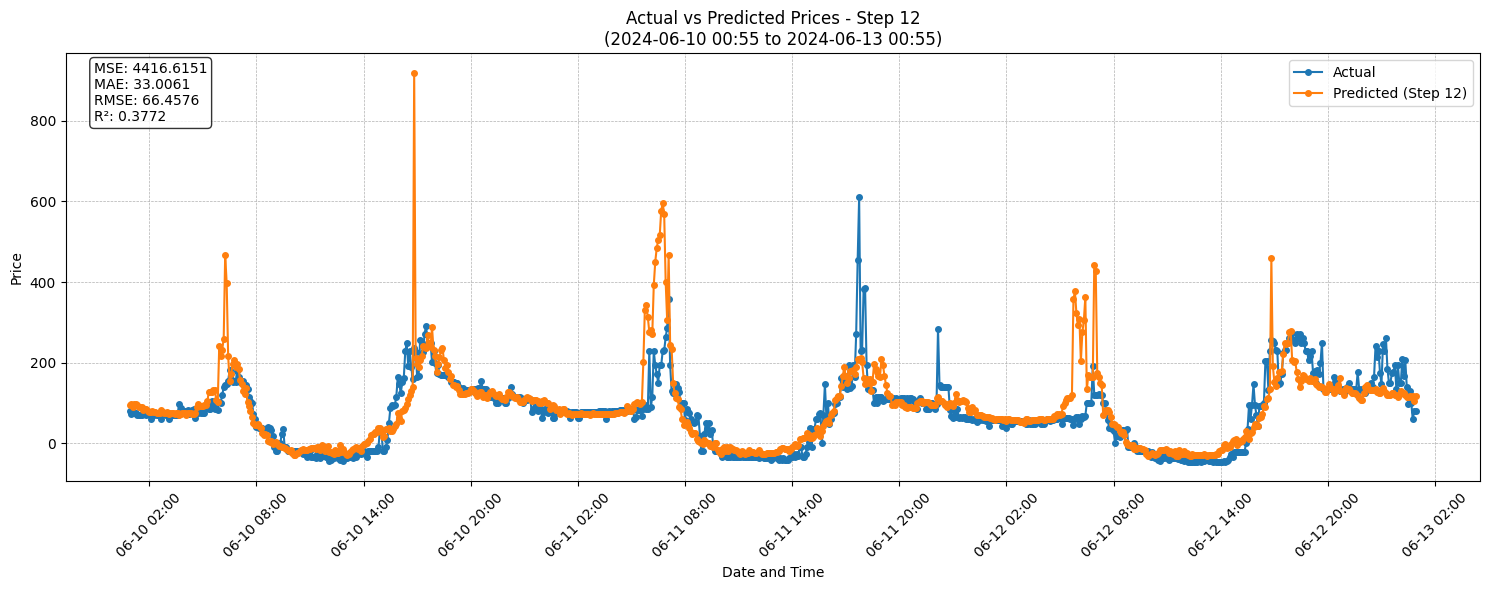

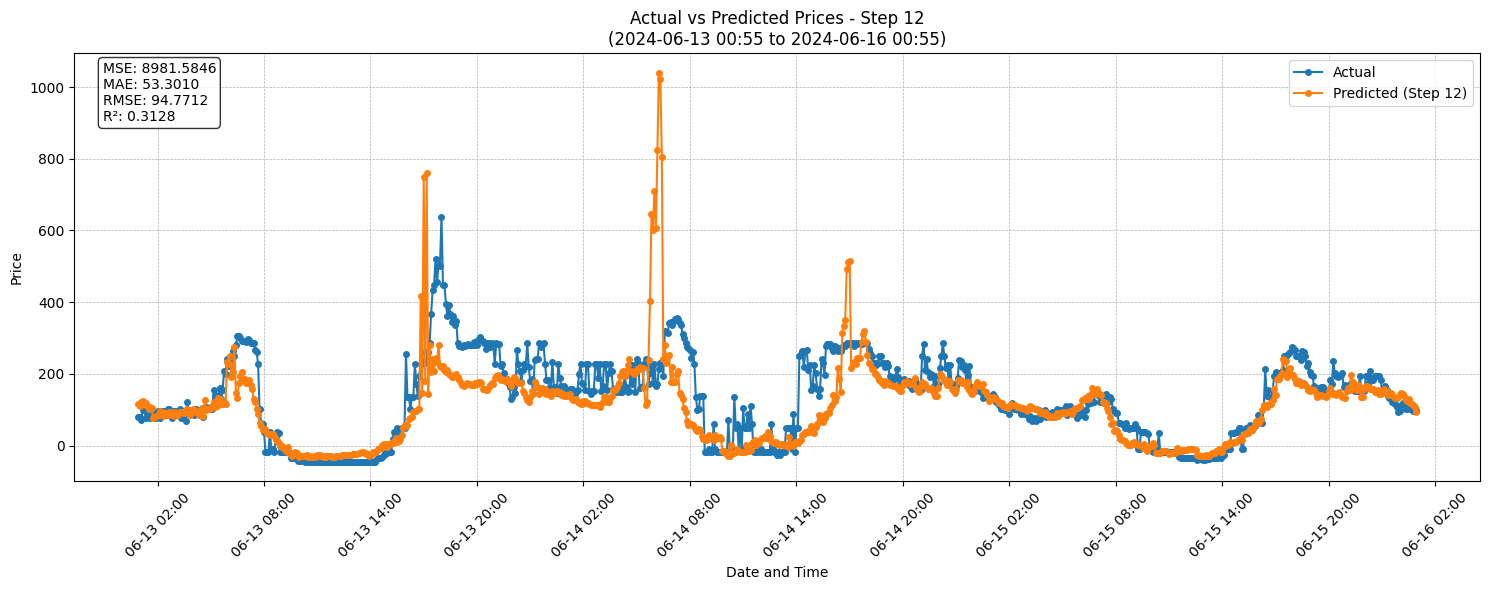

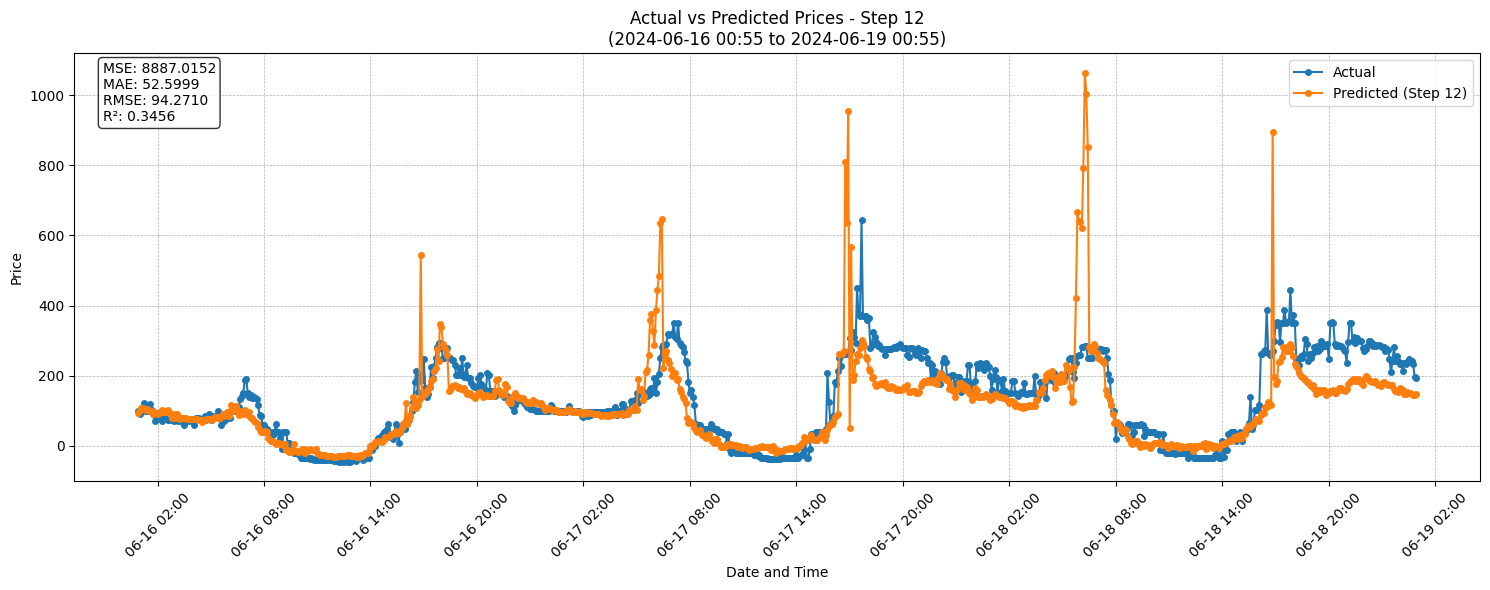

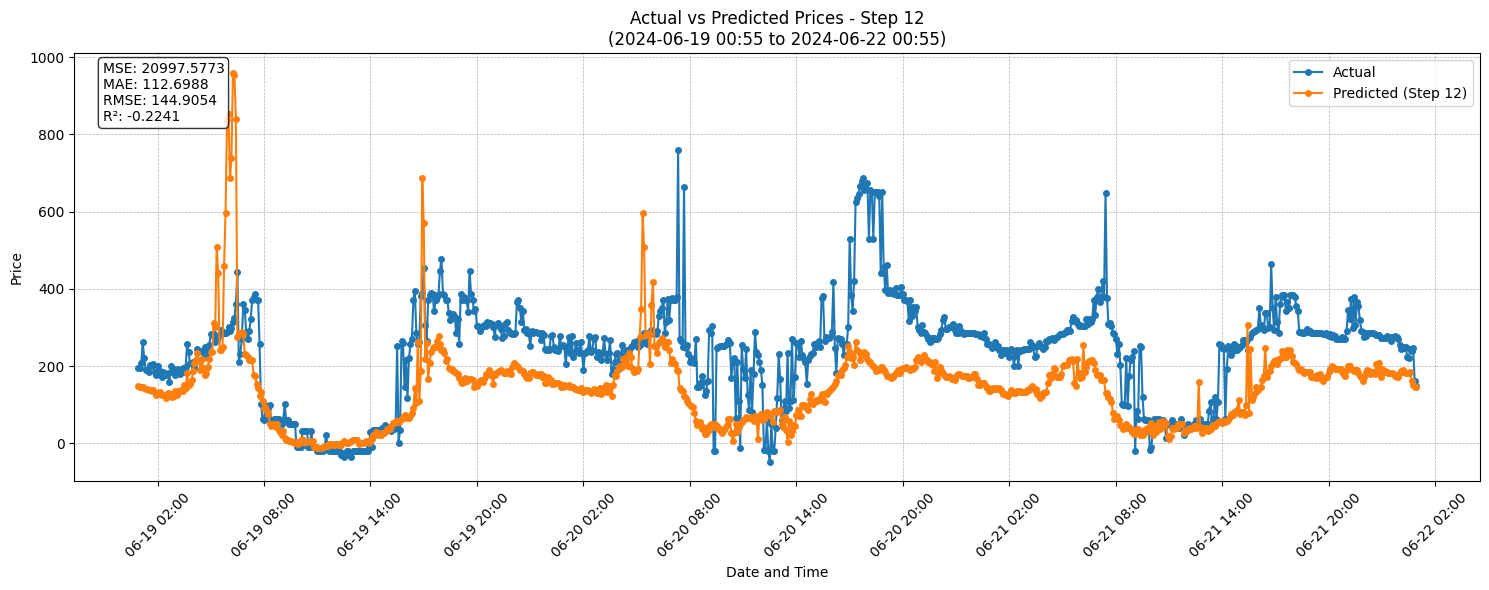

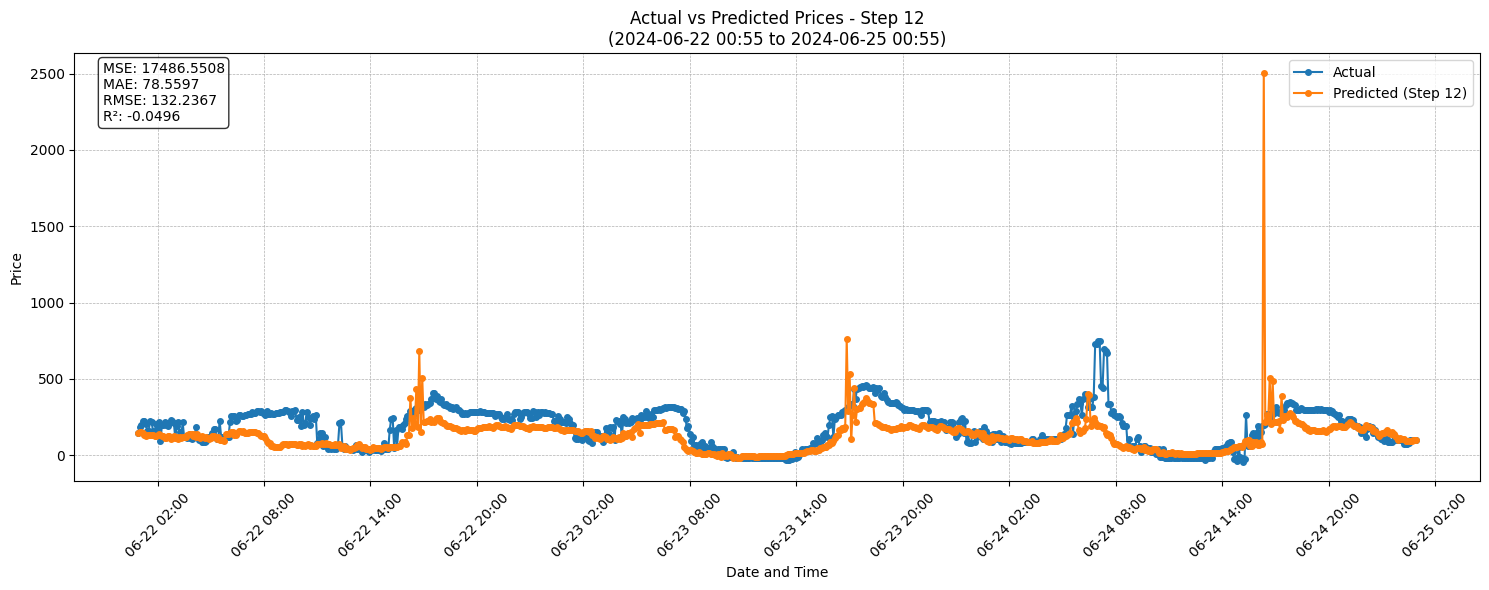

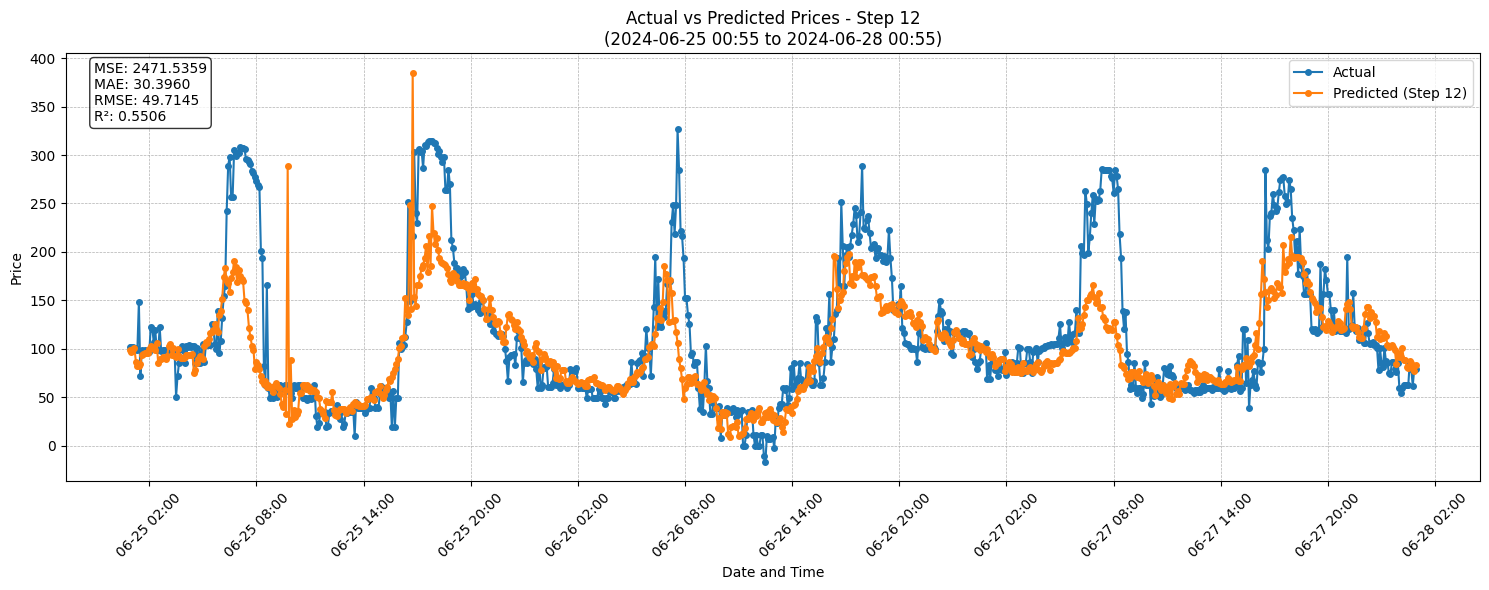

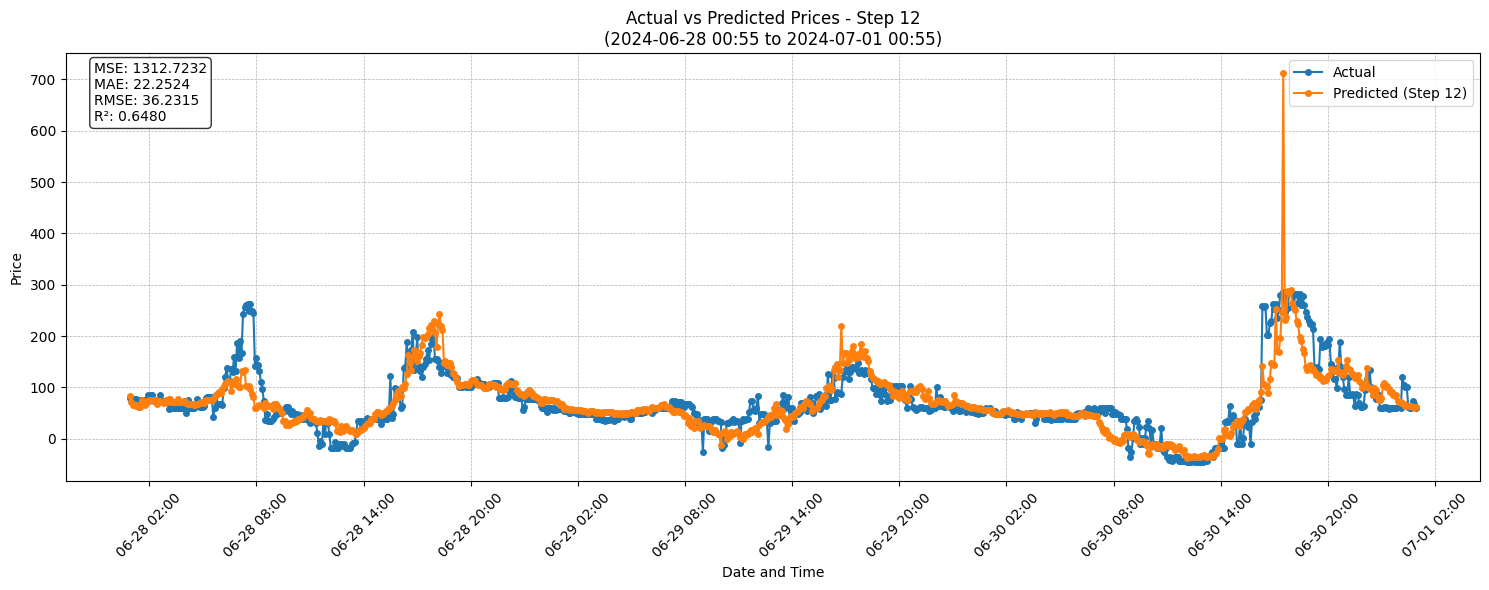

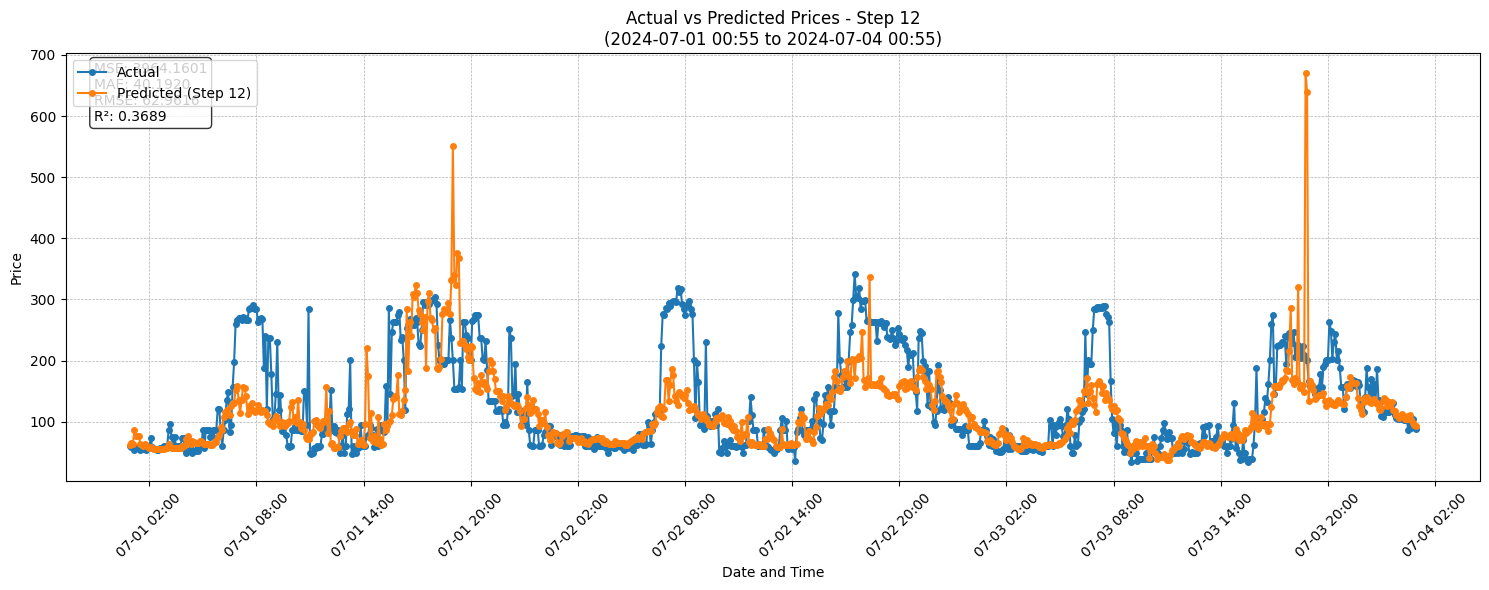

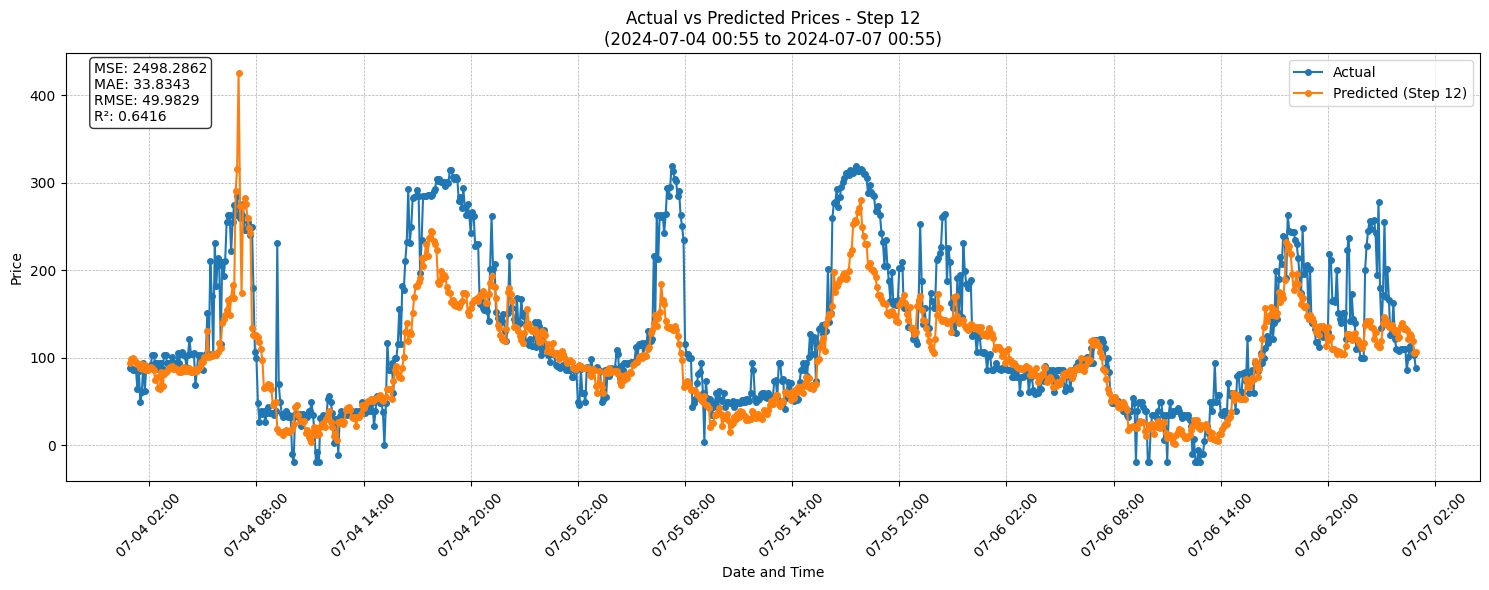

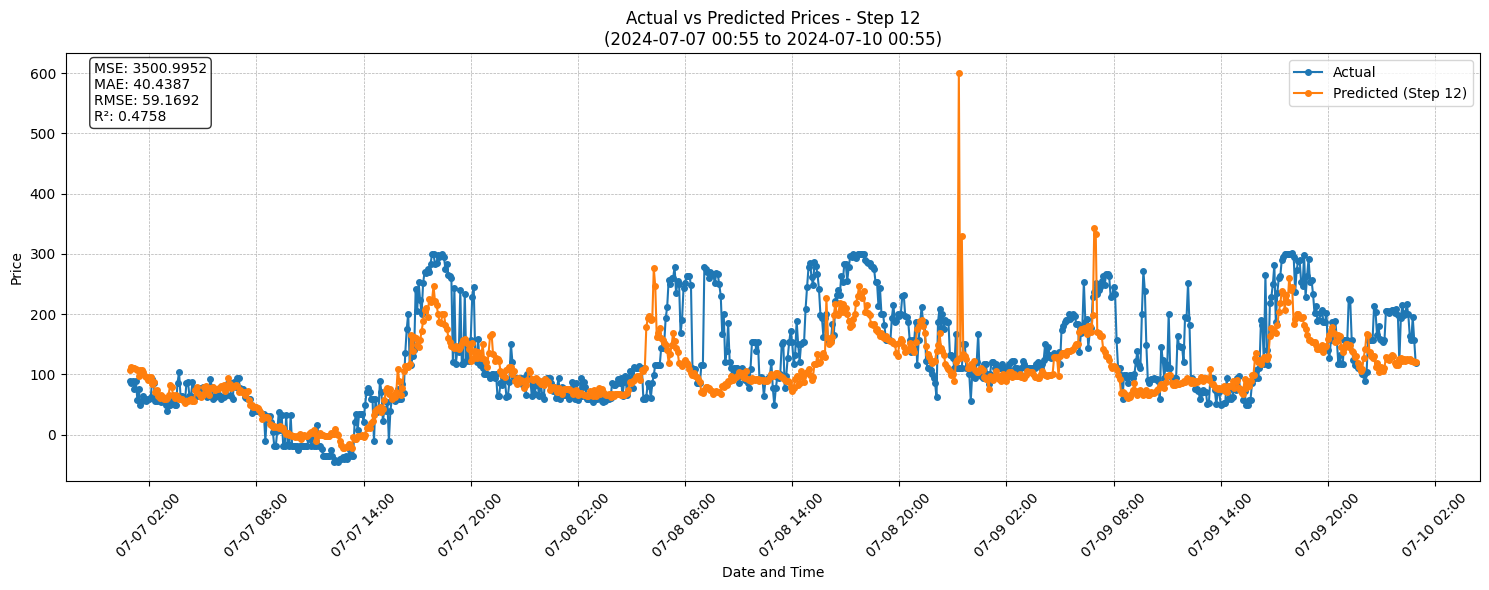

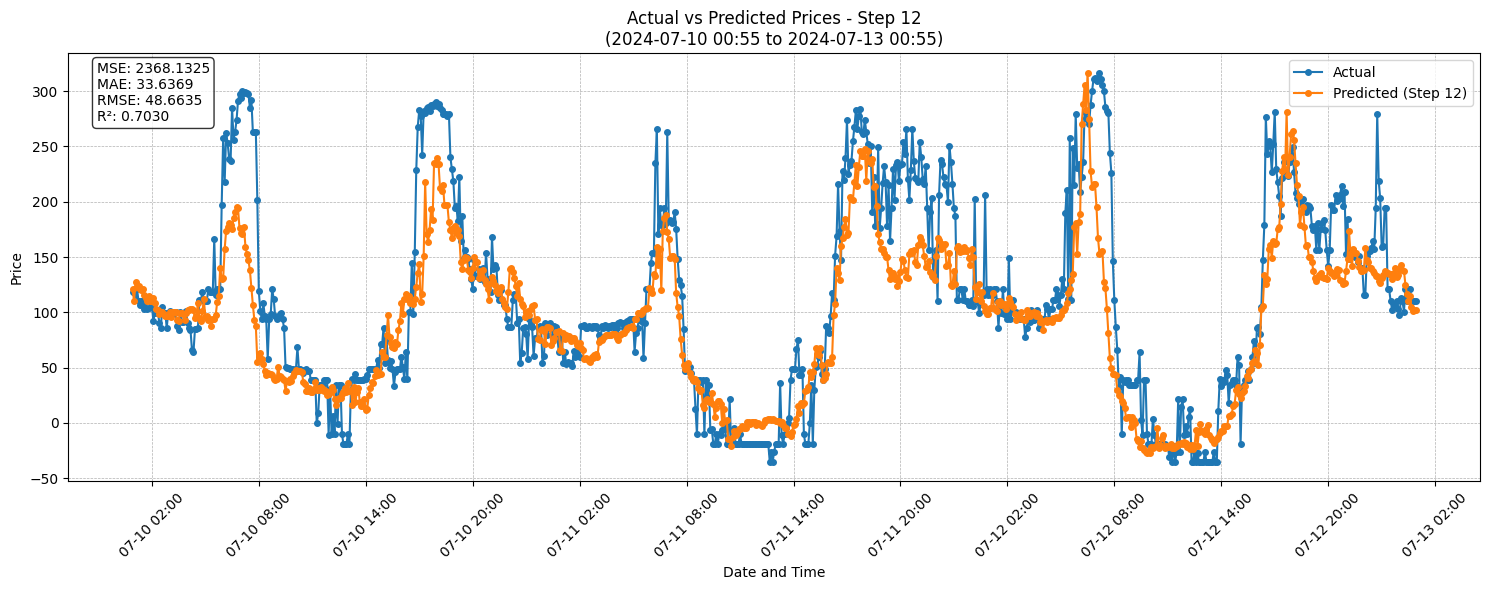

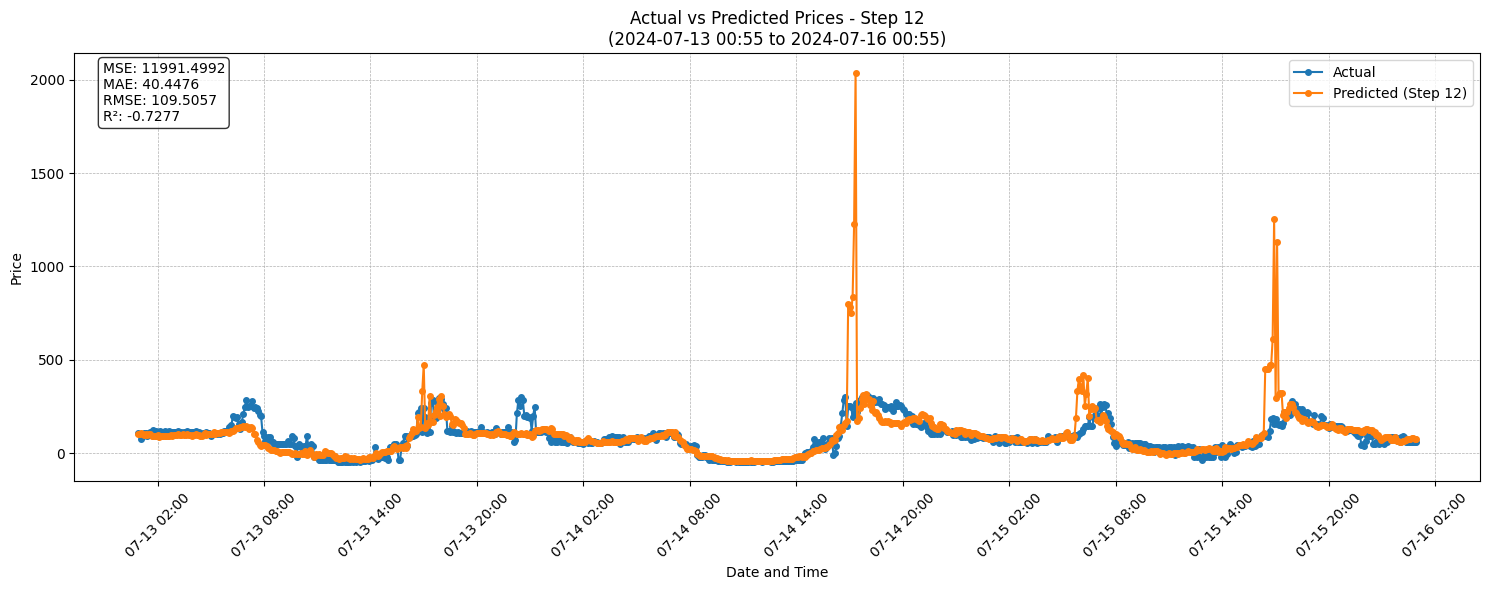

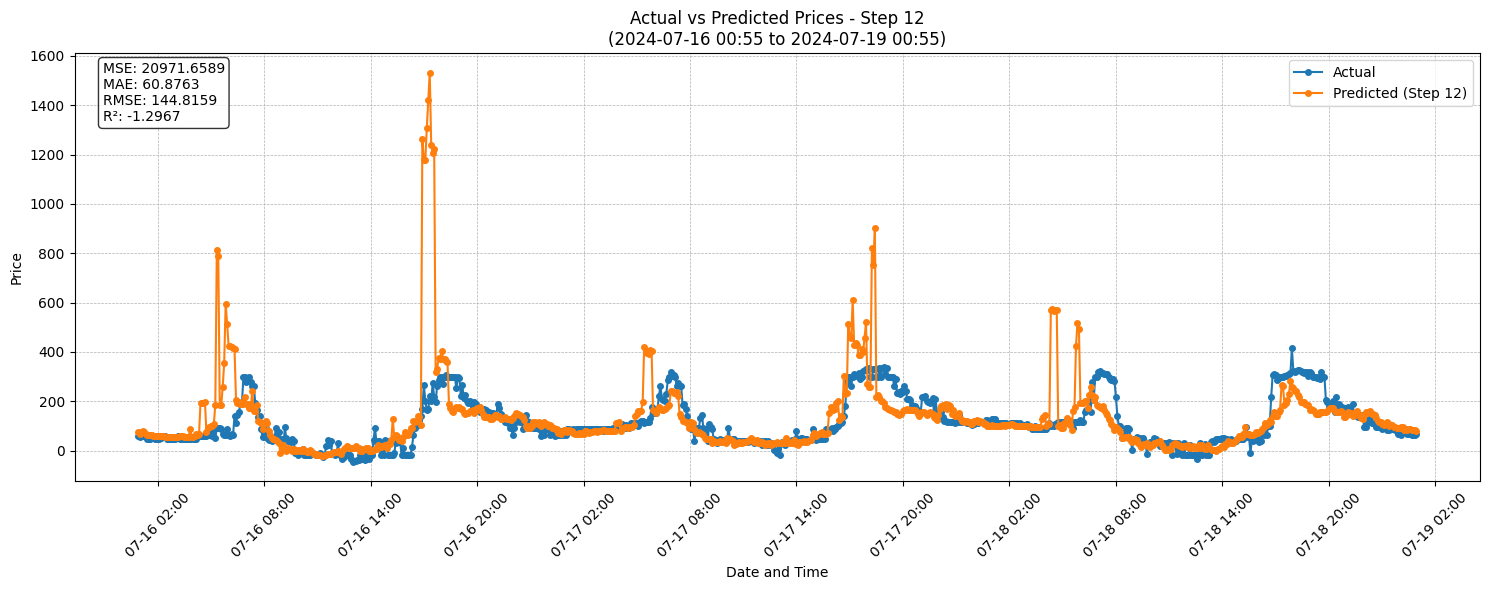

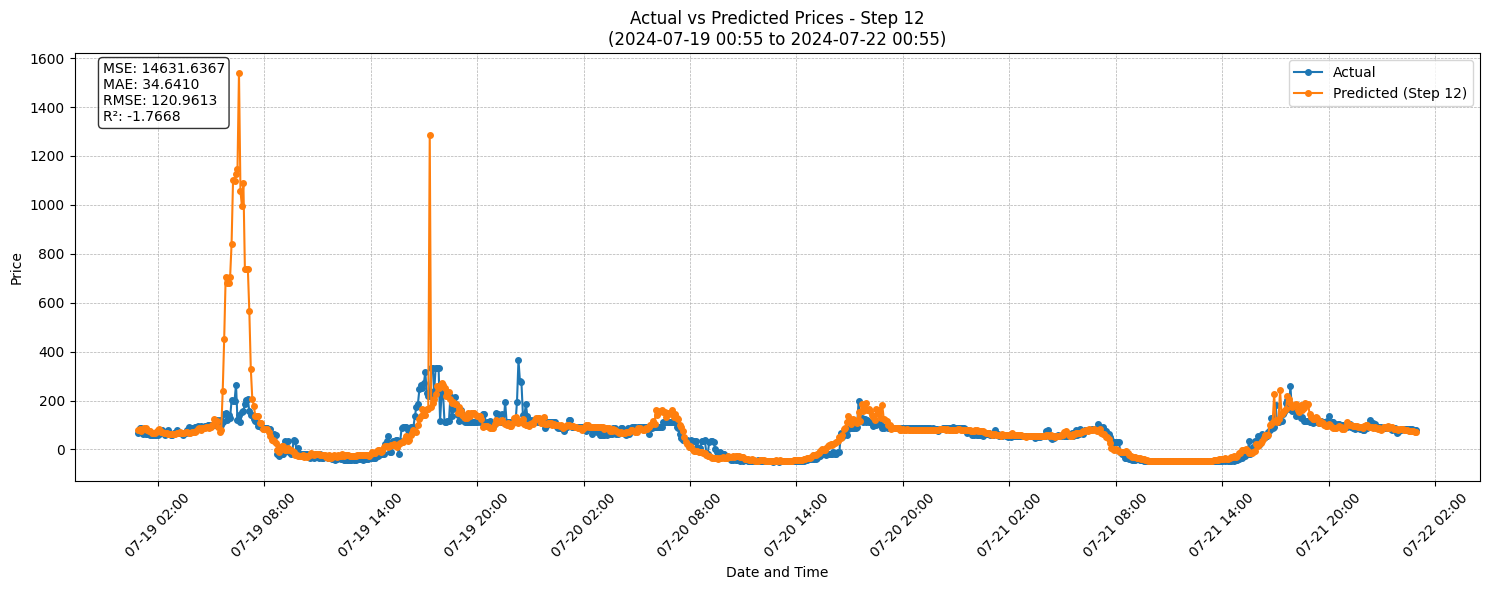

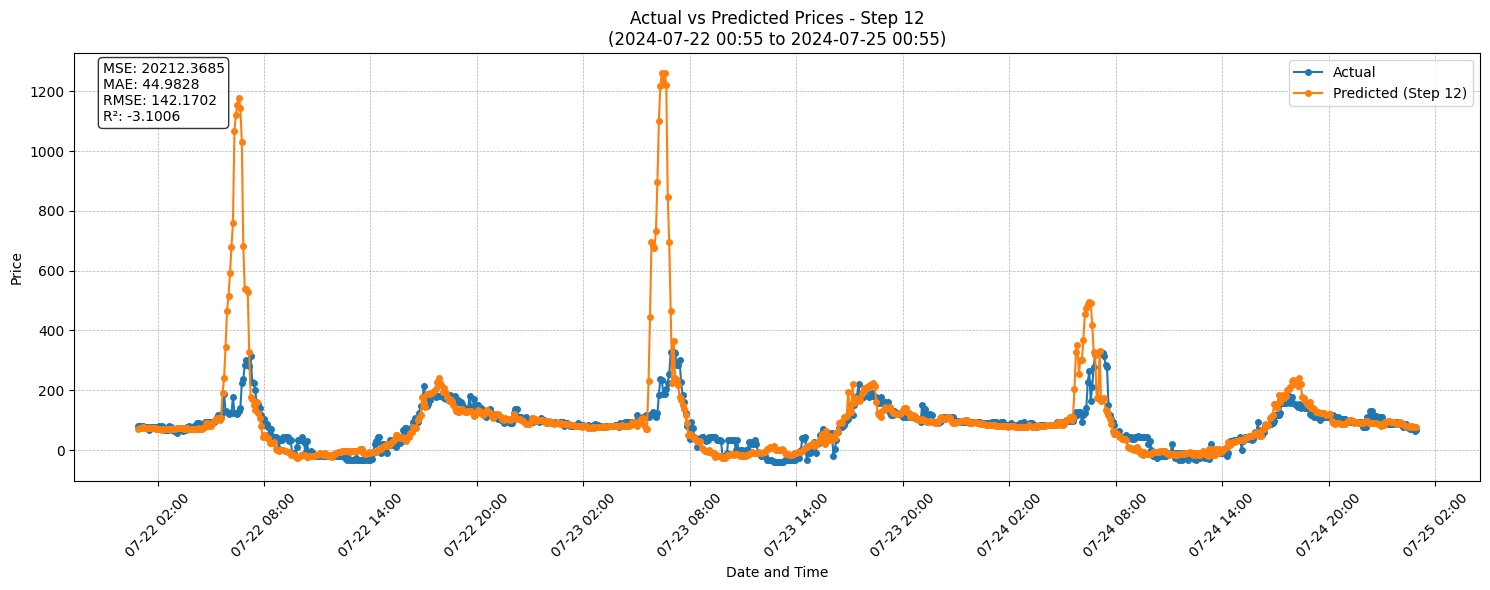

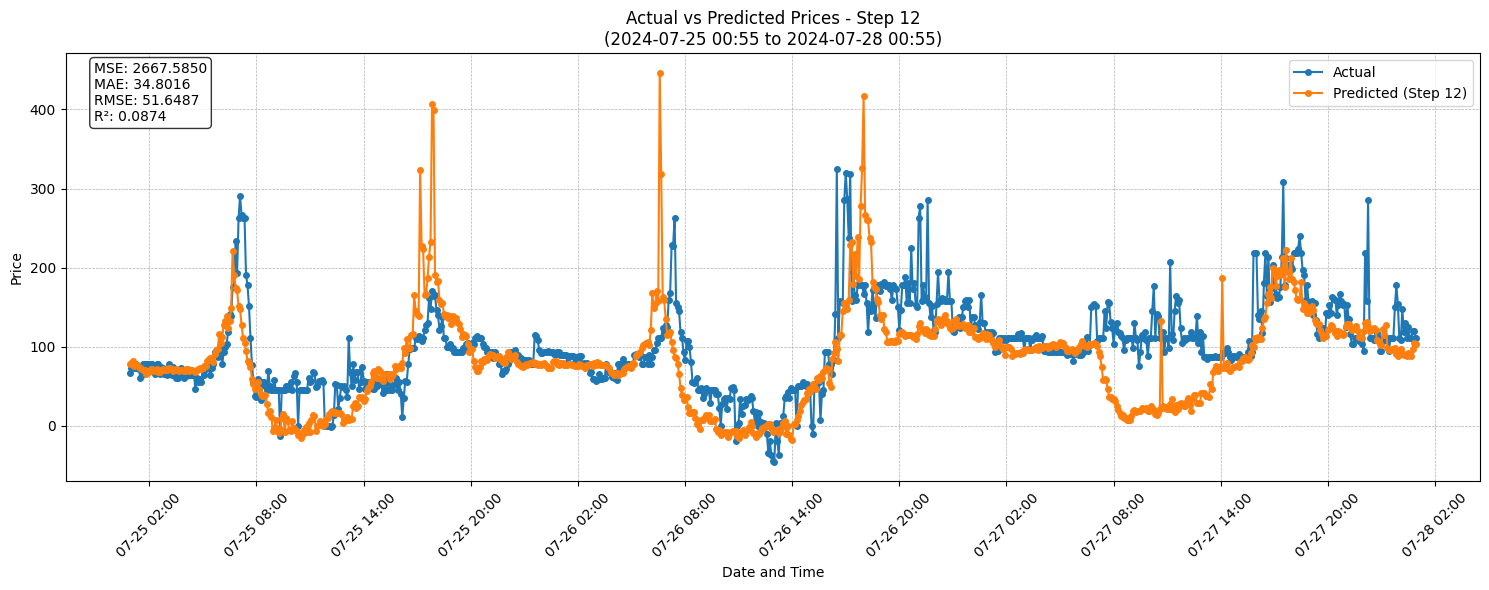

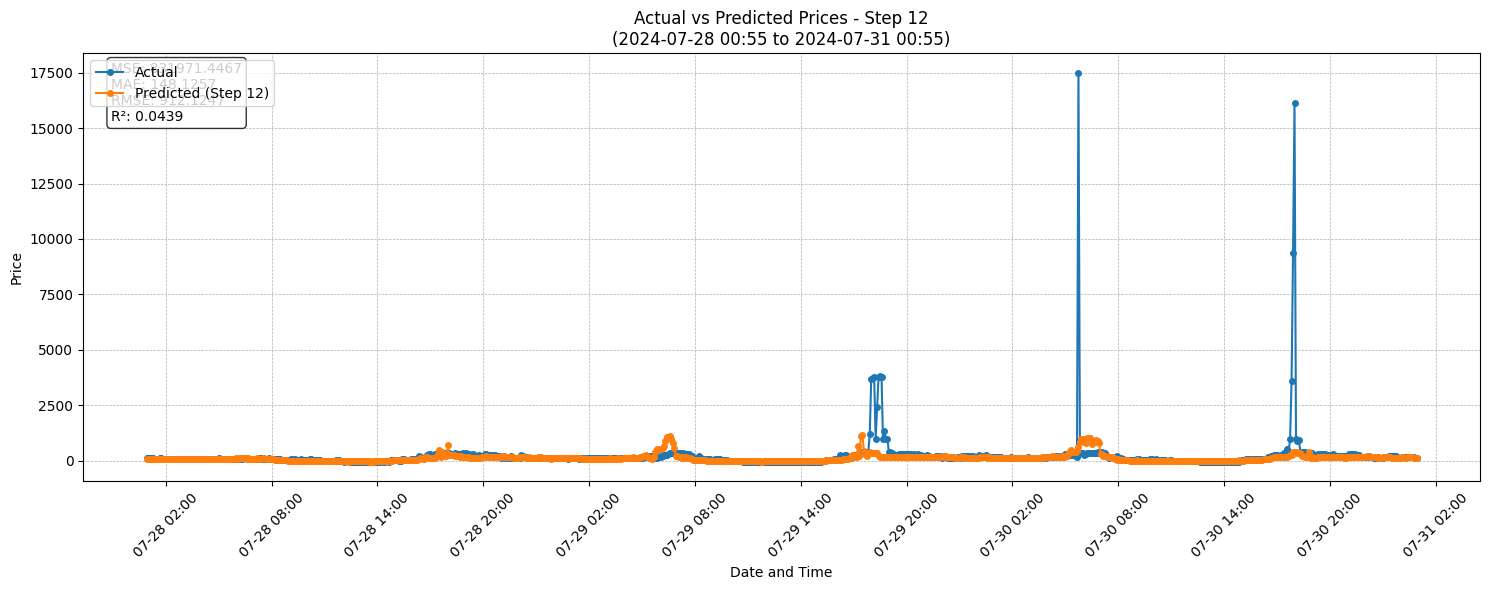

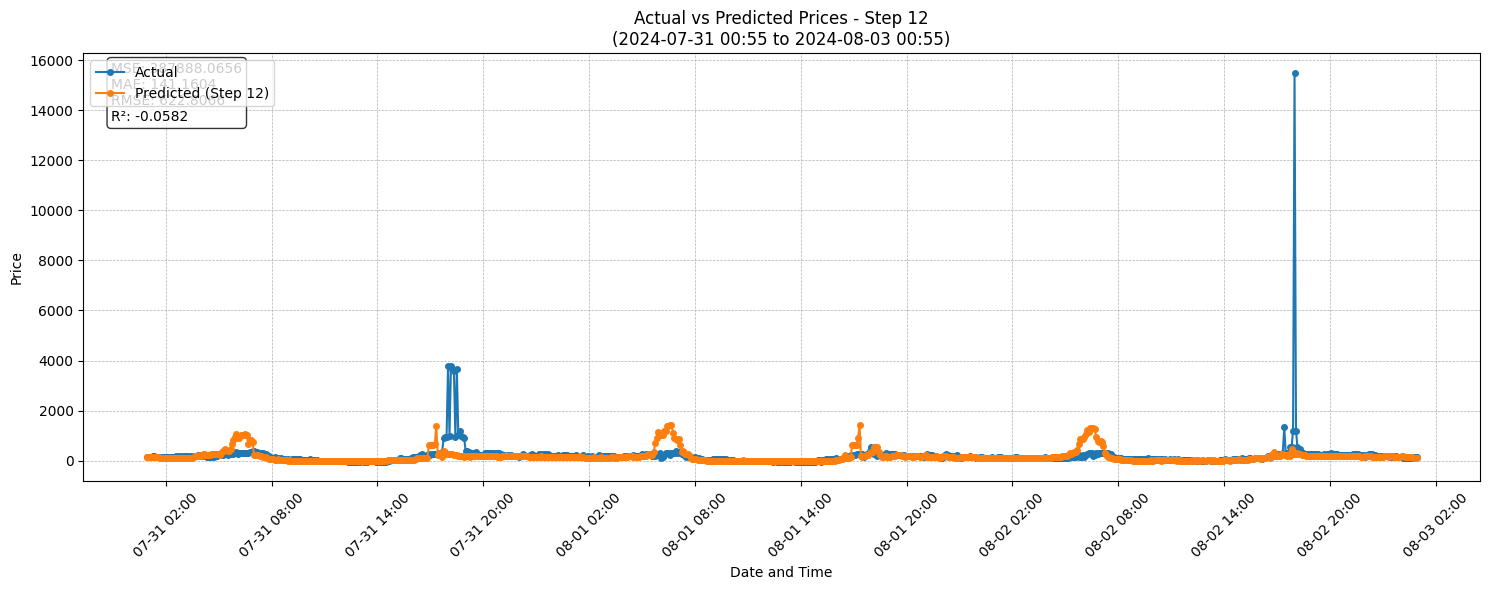

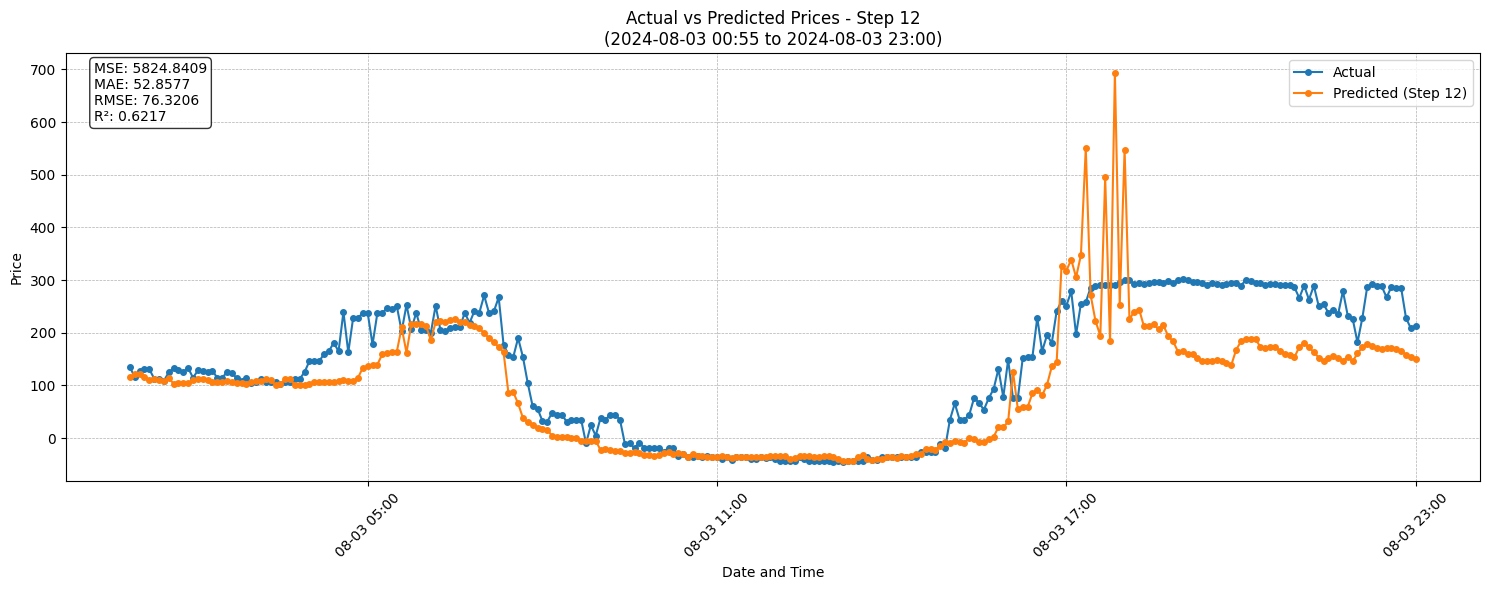

Overall Performance Metrics for Step 6:
Mean Squared Error: 60036.2134
Mean Absolute Error: 45.1801
Root Mean Squared Error: 245.0229
R-squared Score: 0.1136


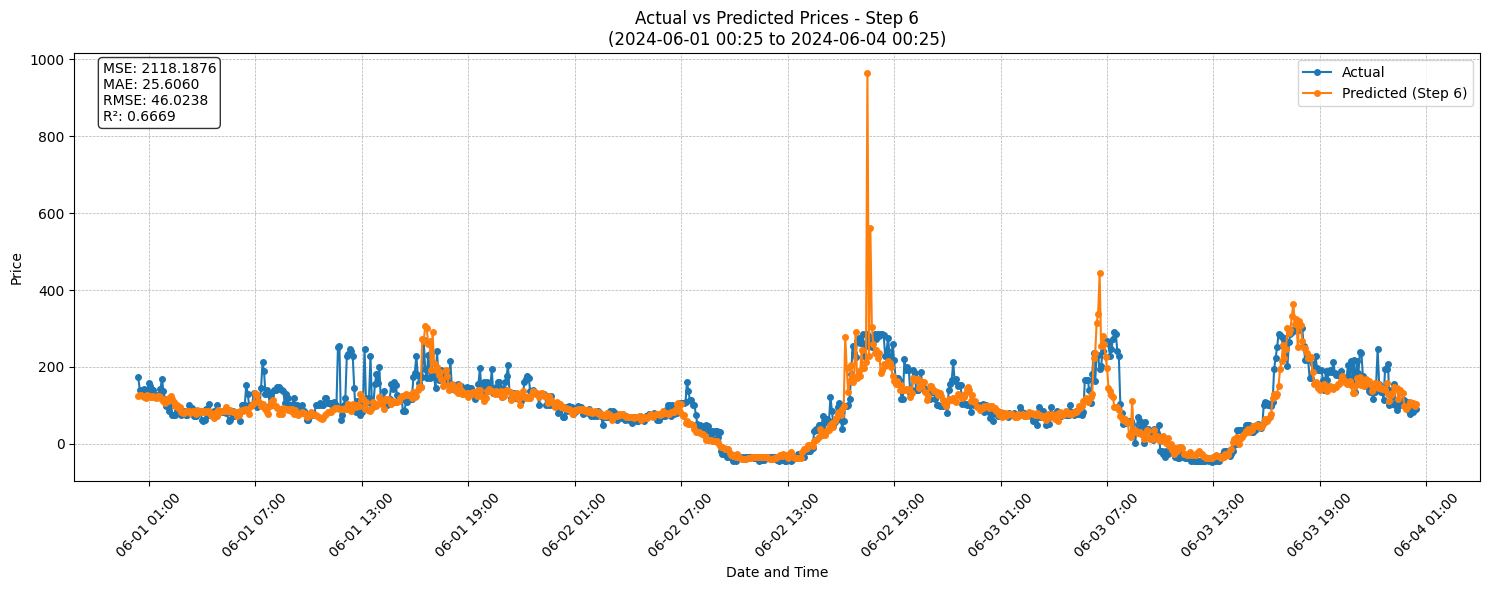

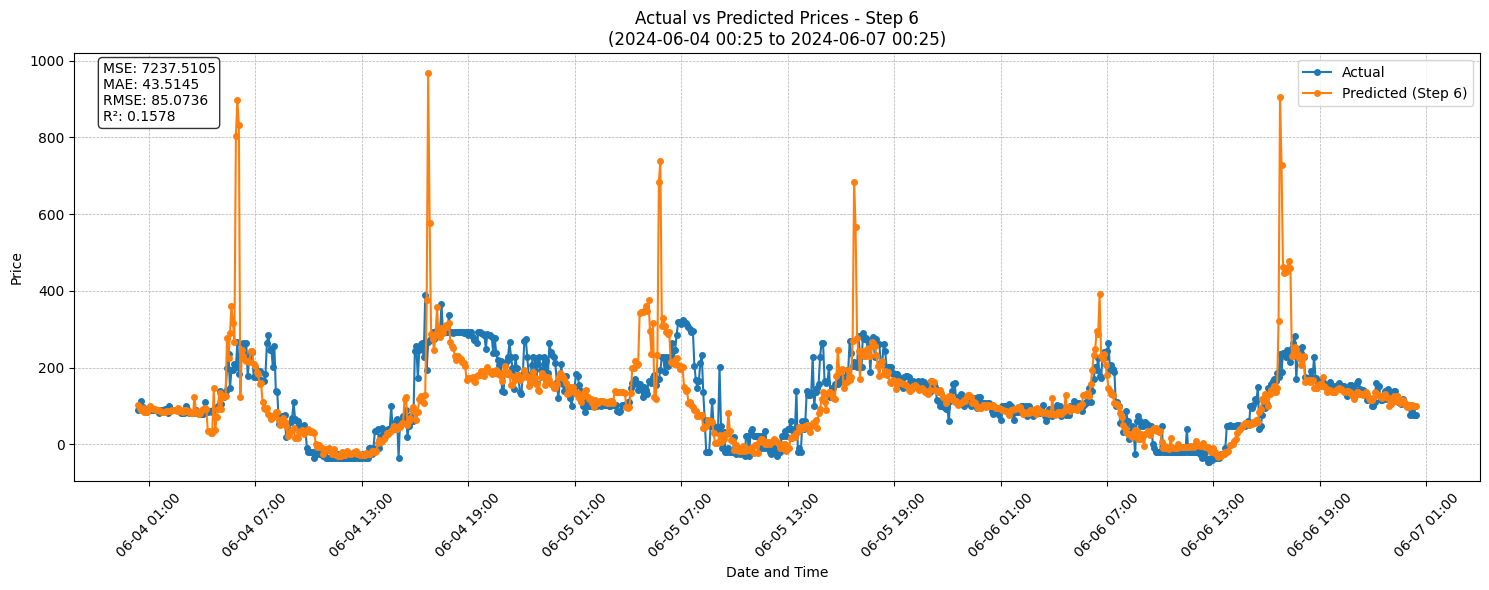

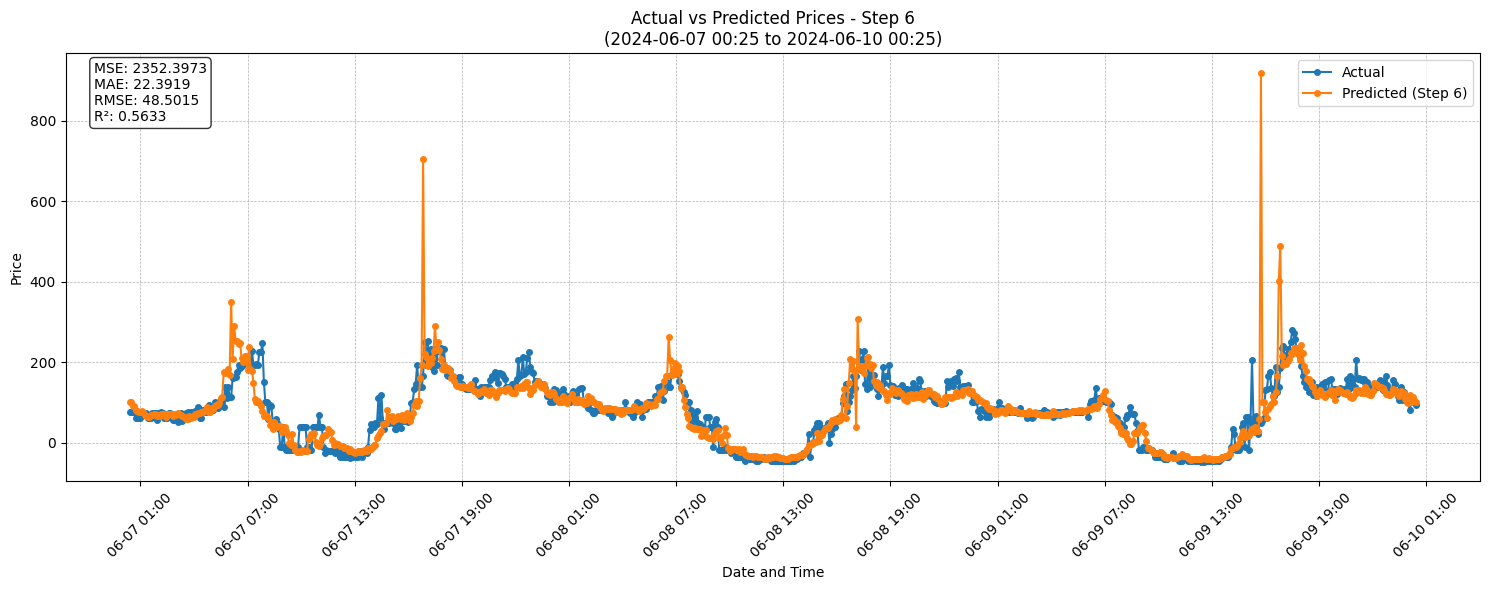

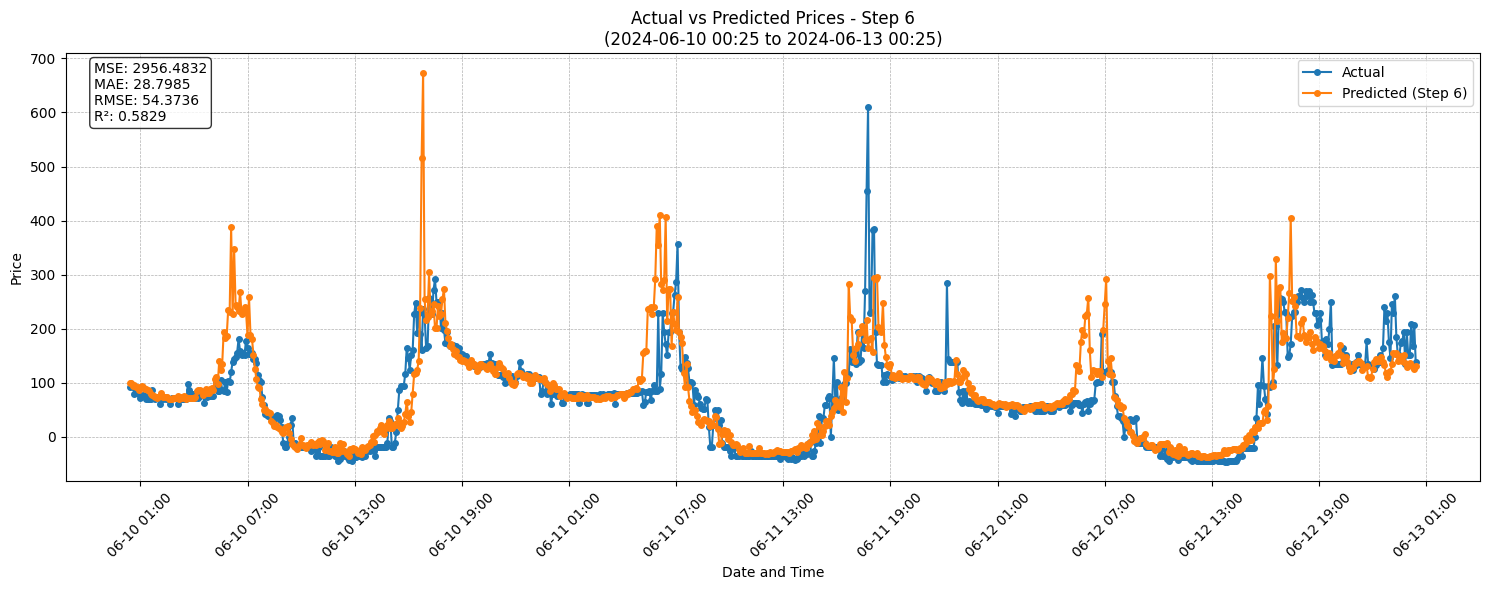

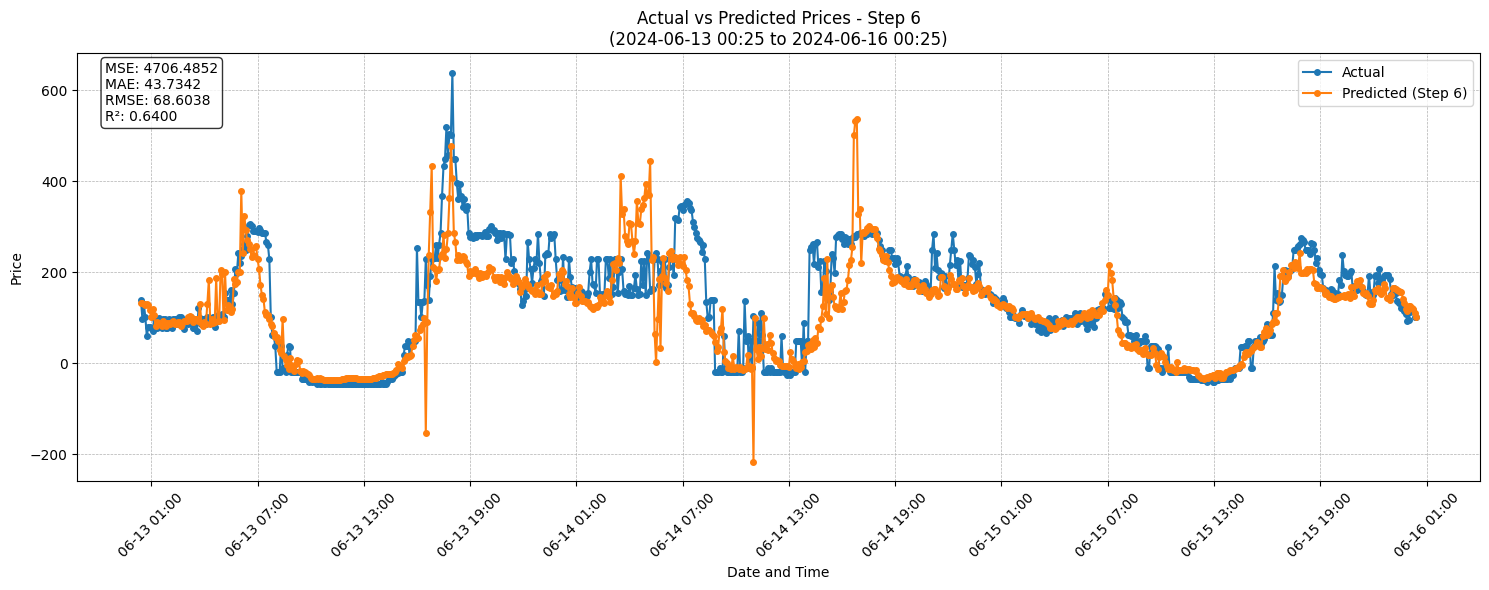

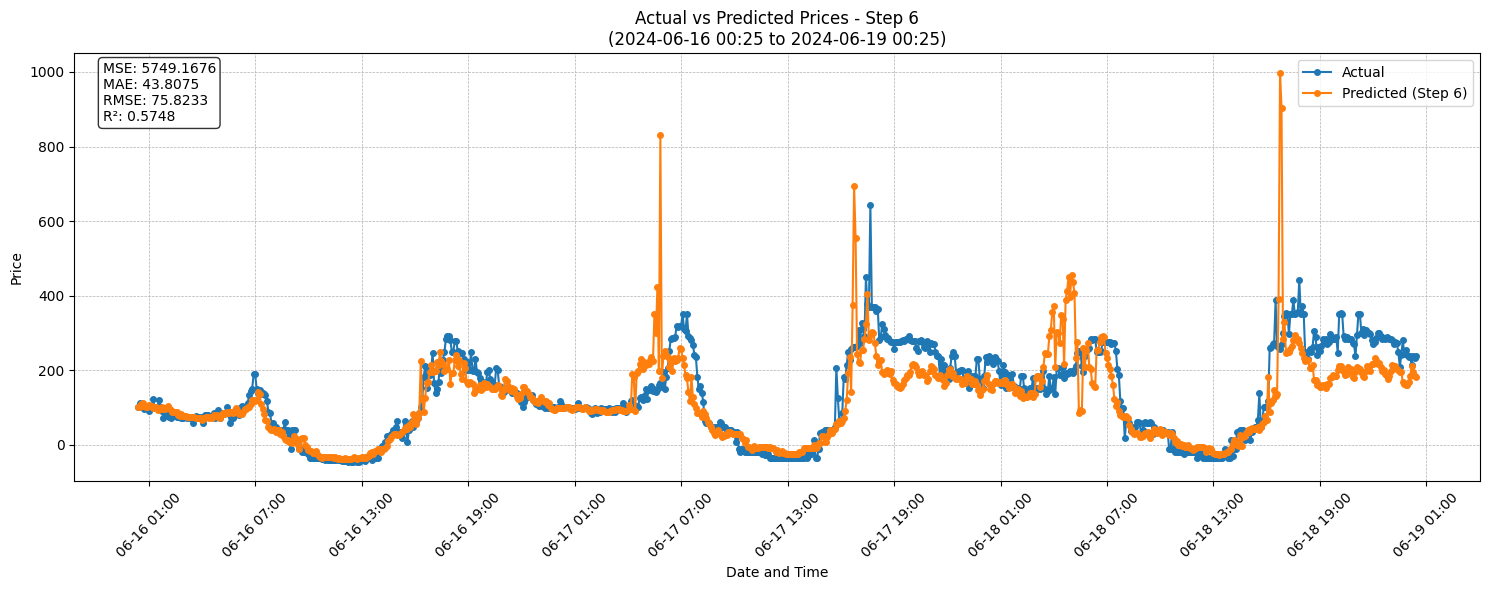

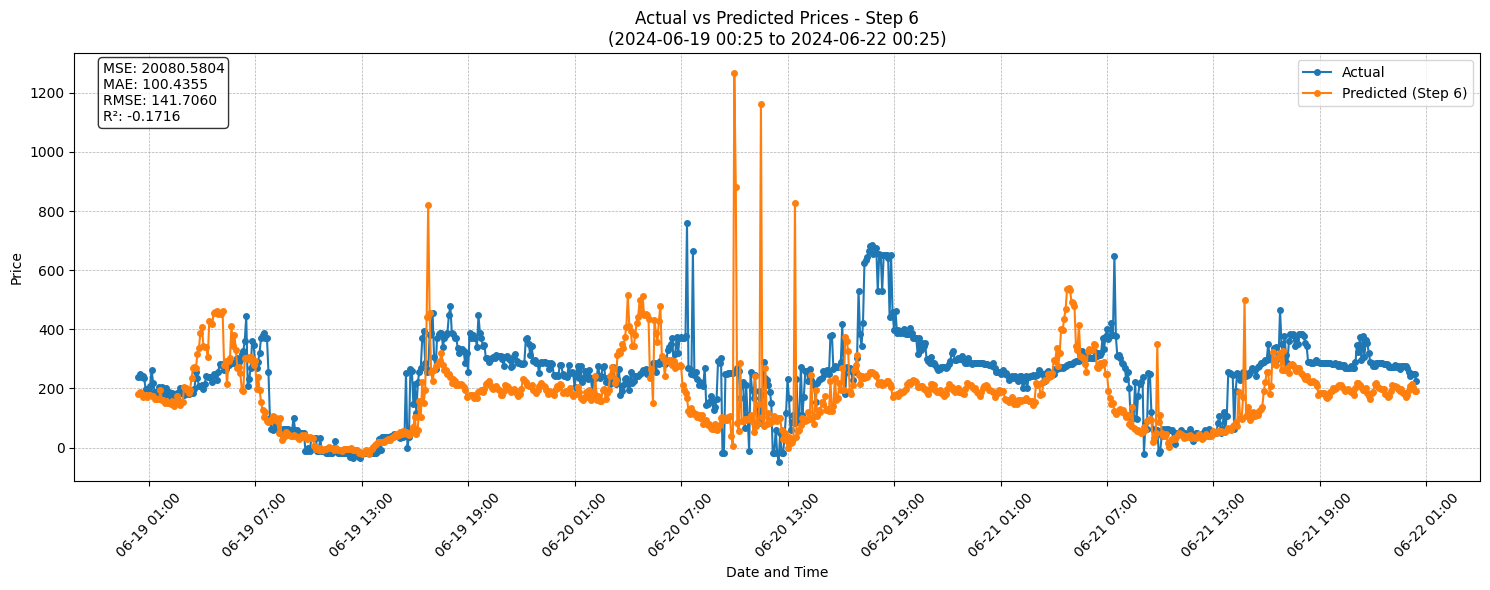

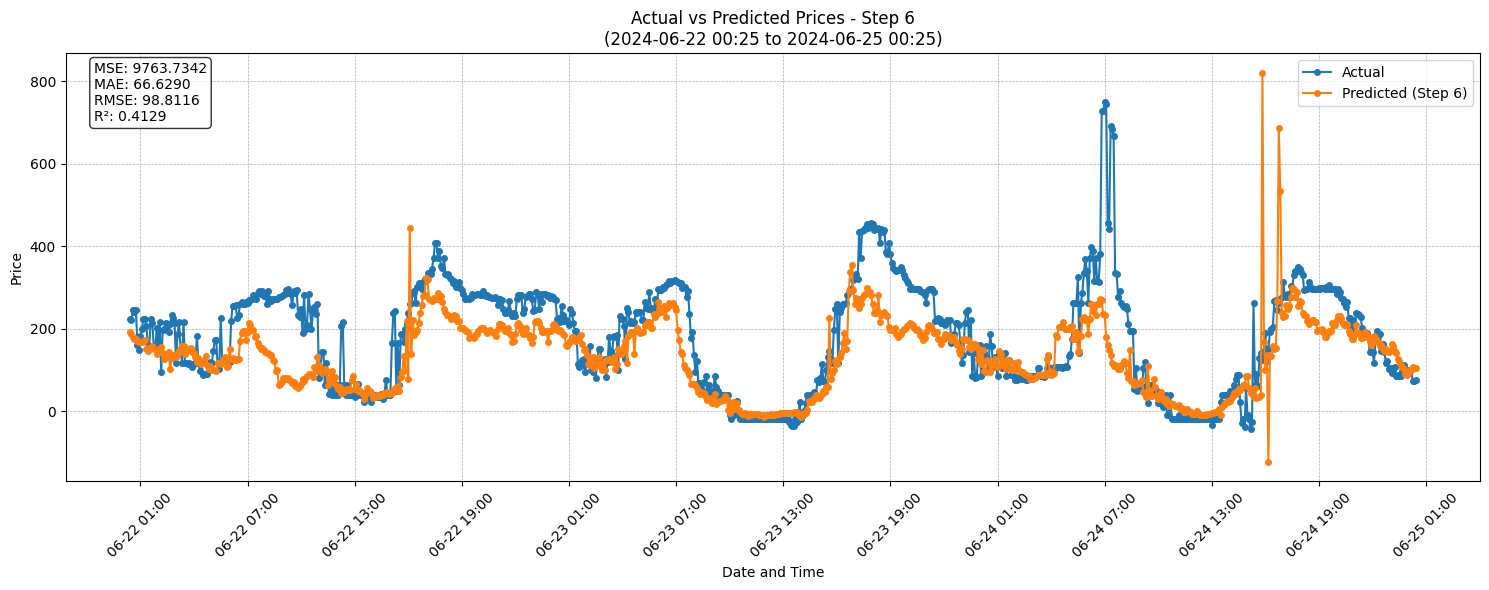

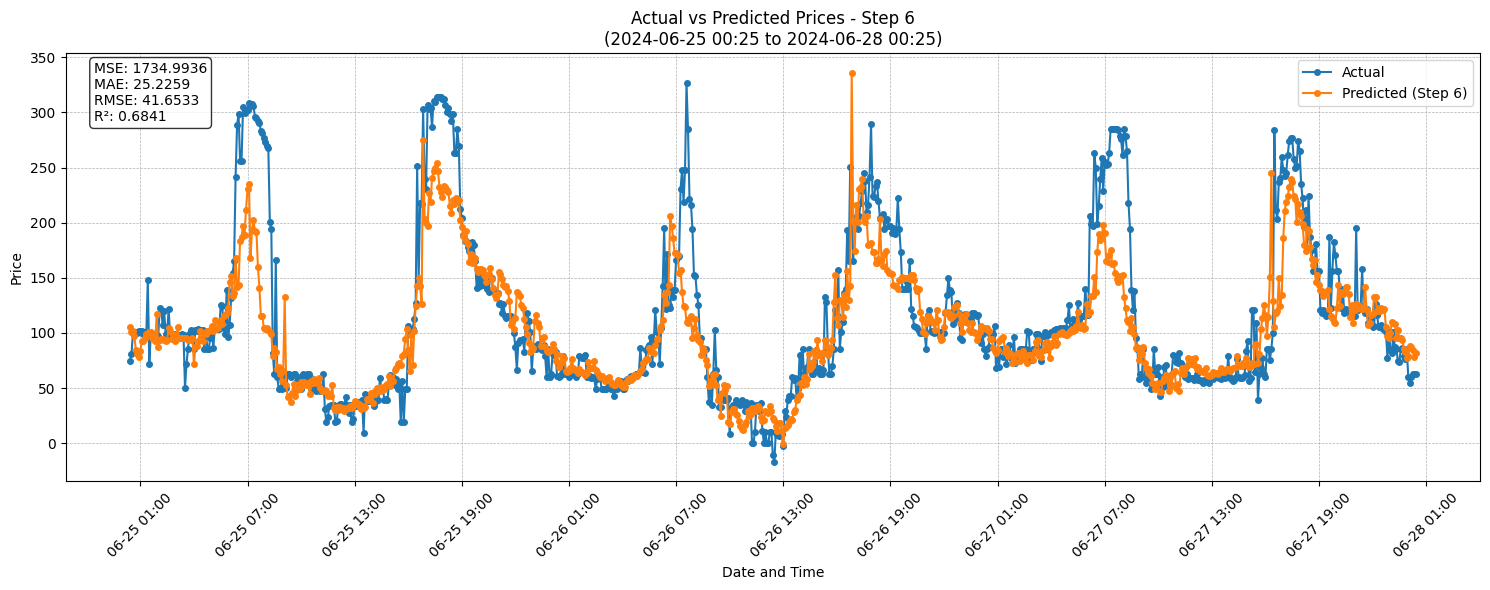

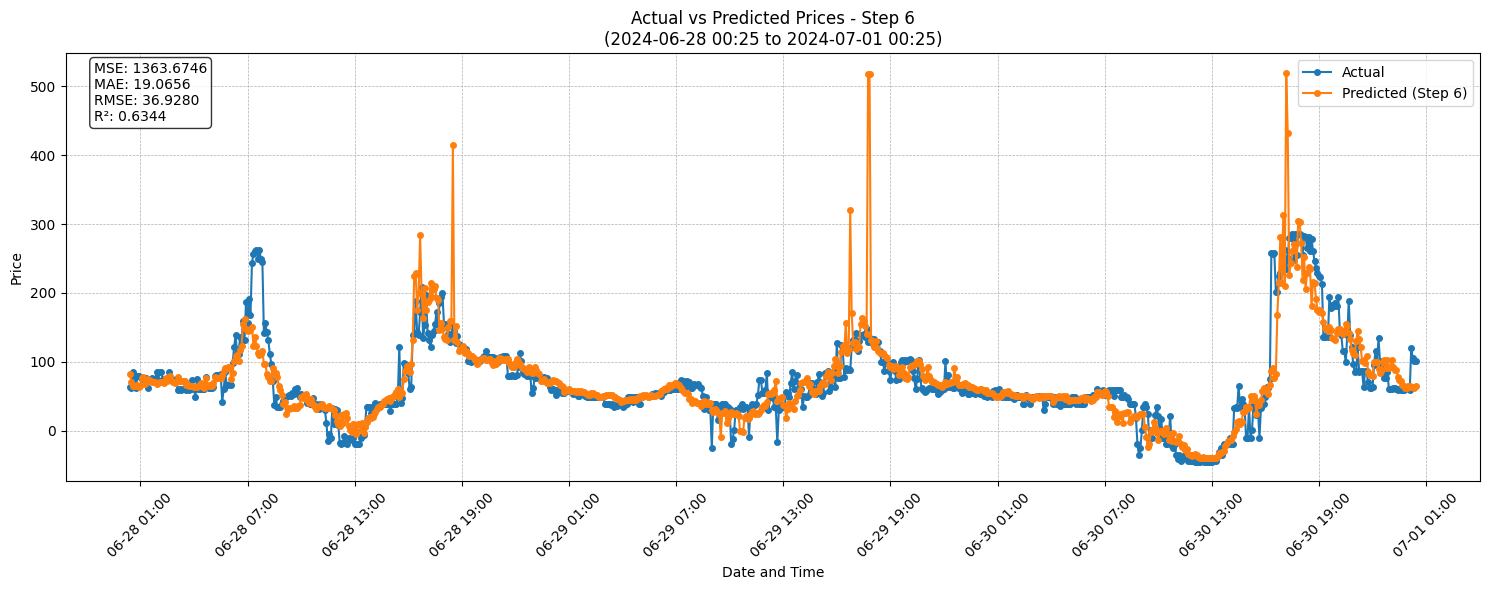

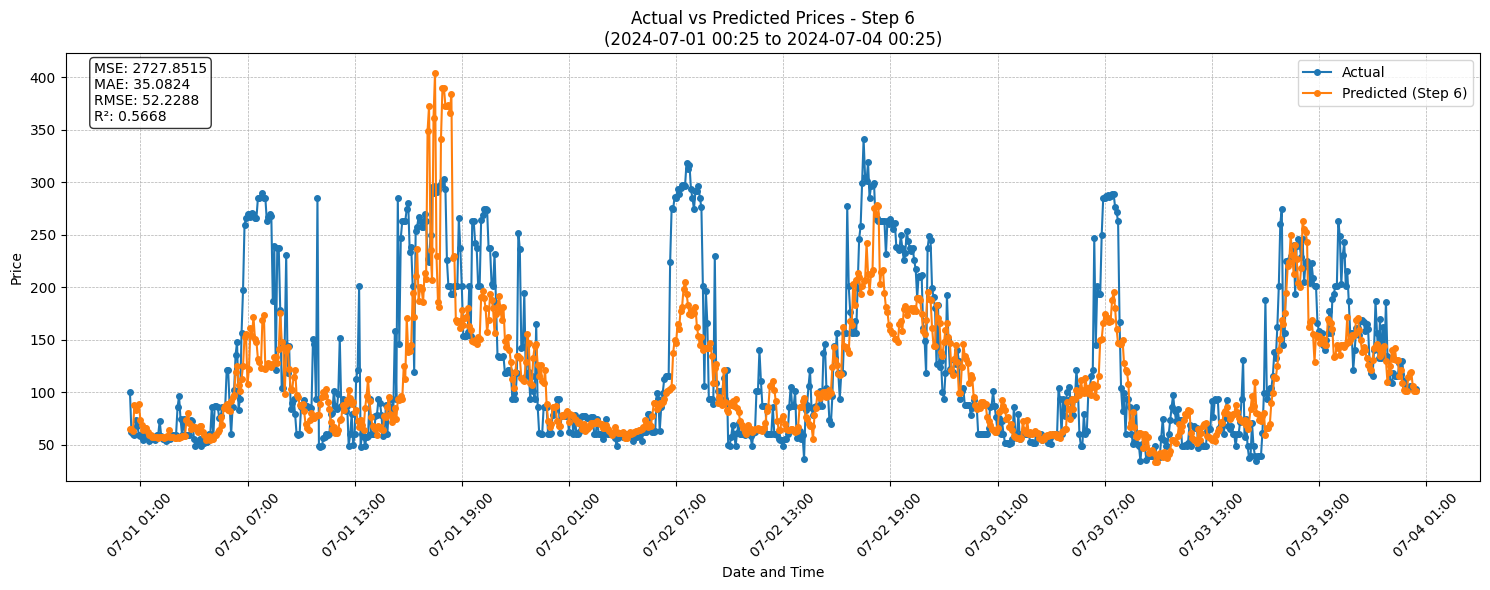

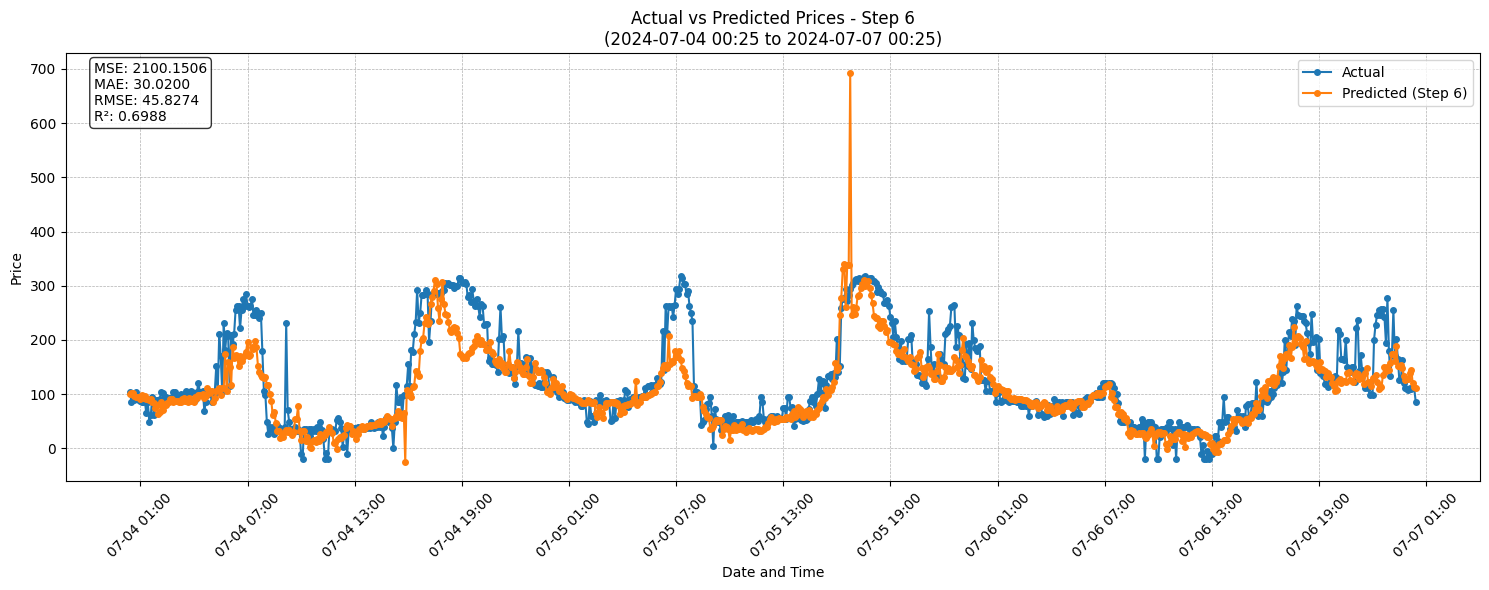

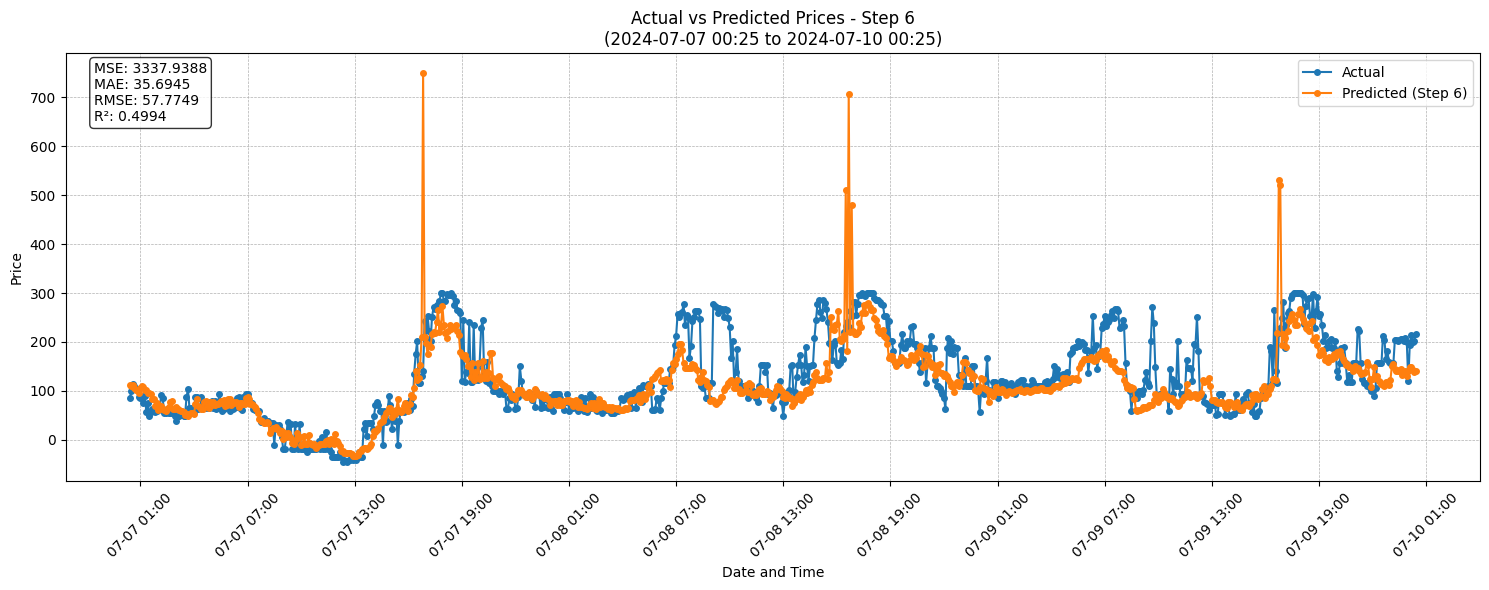

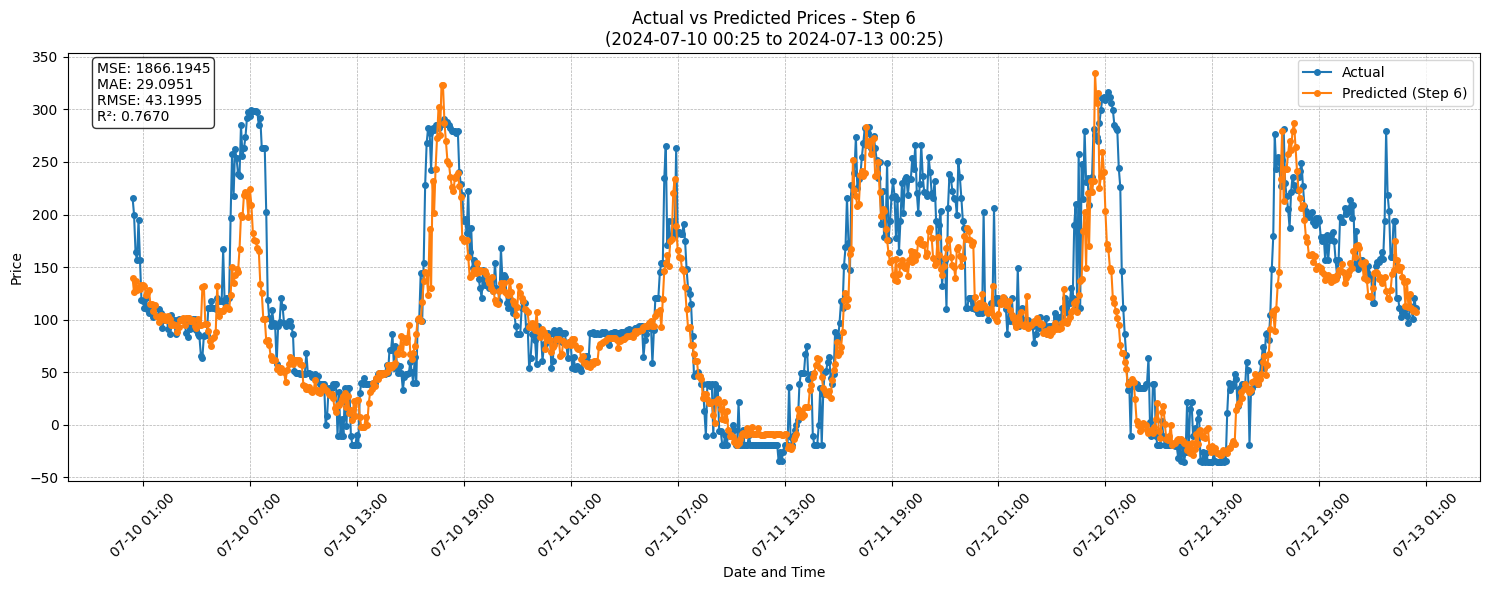

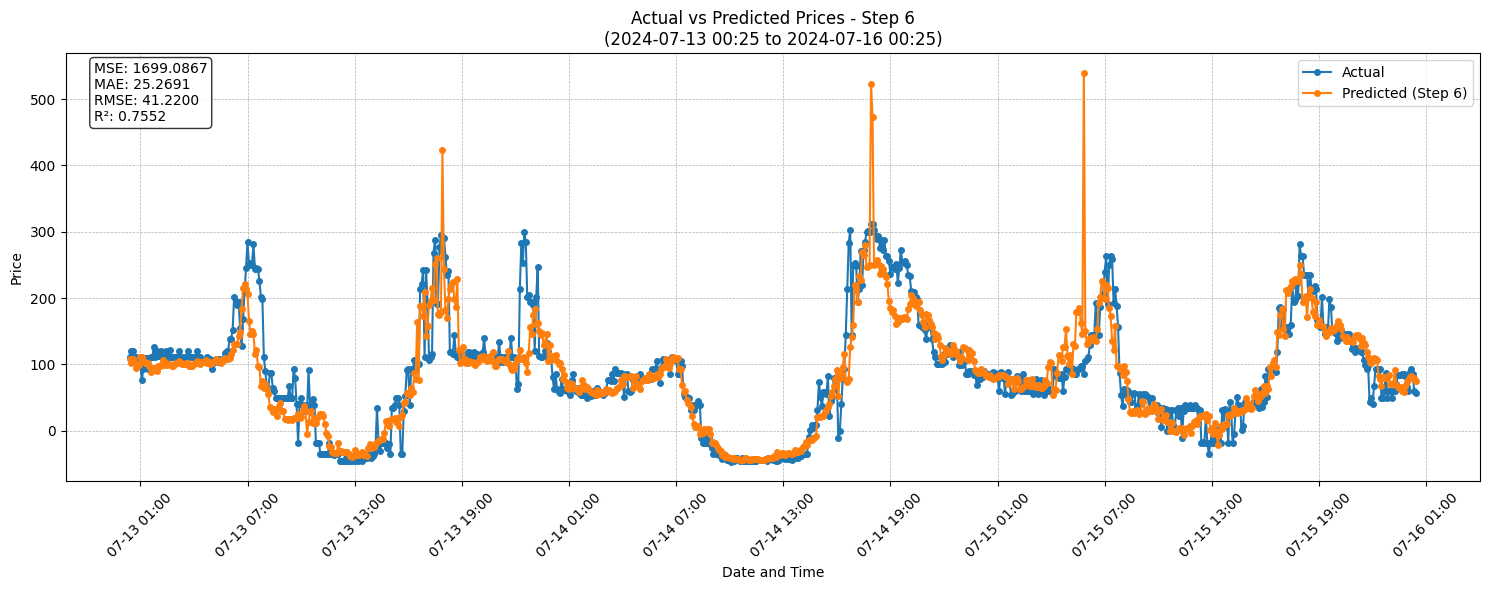

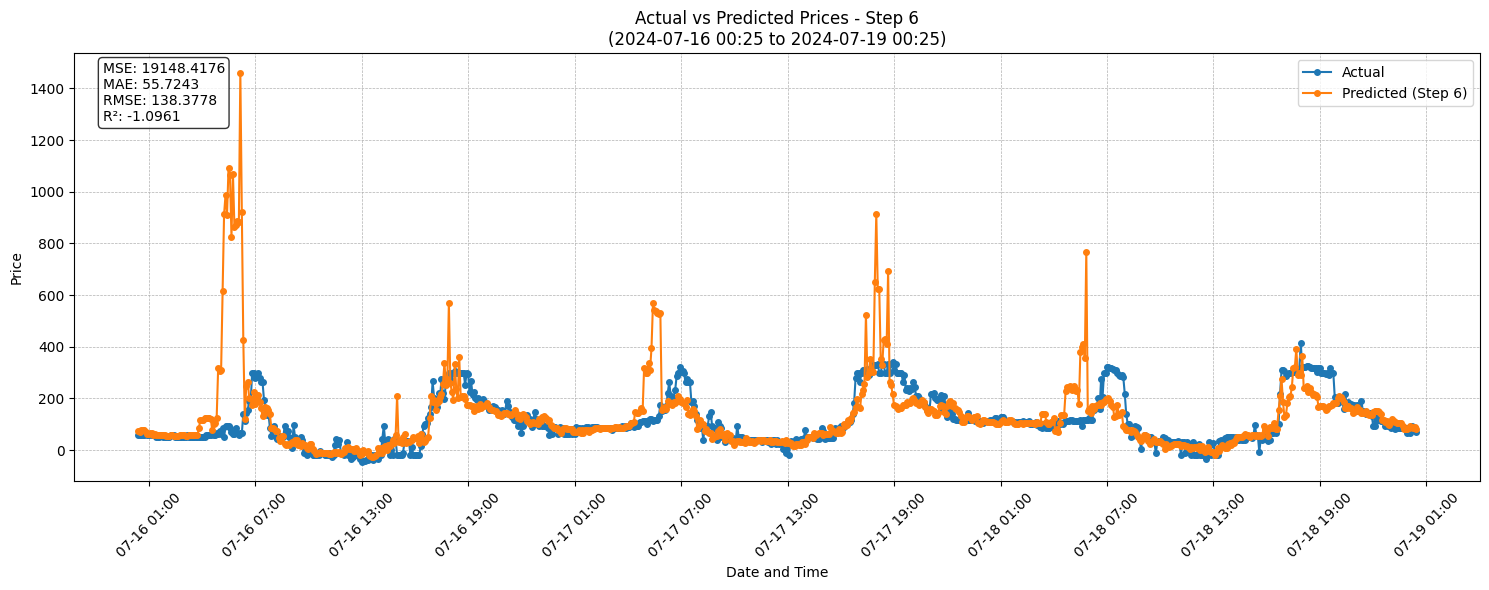

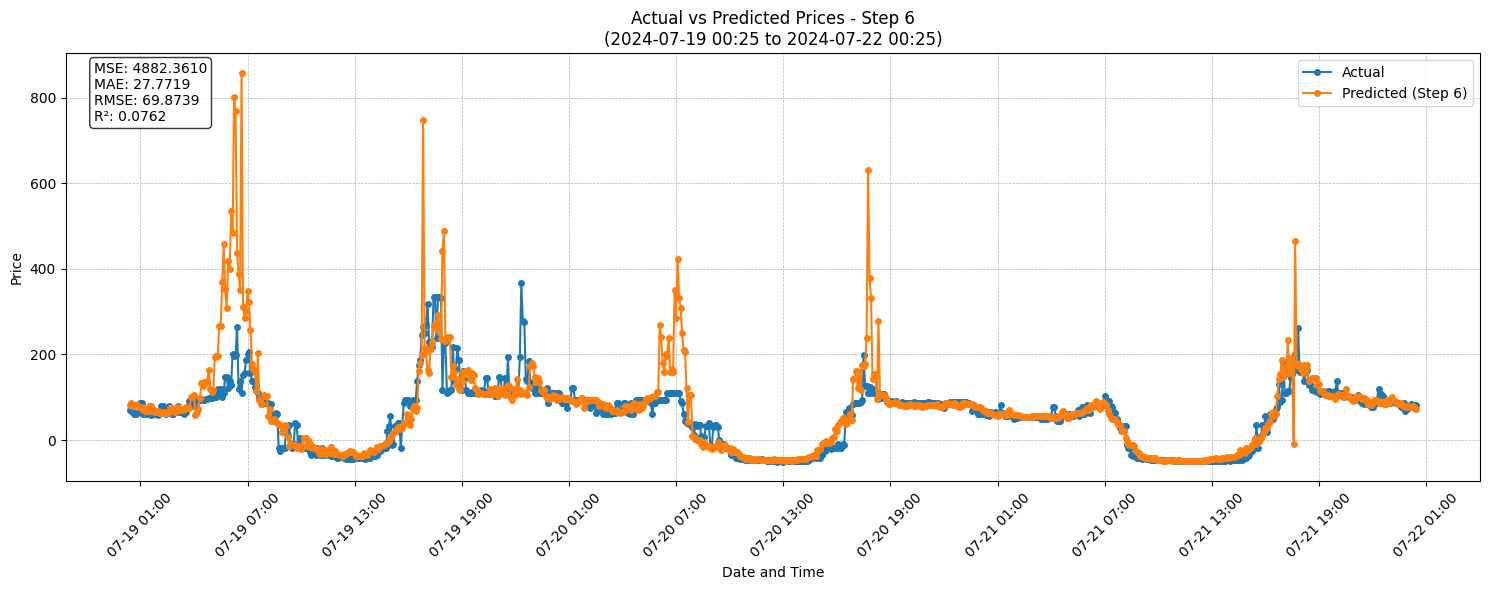

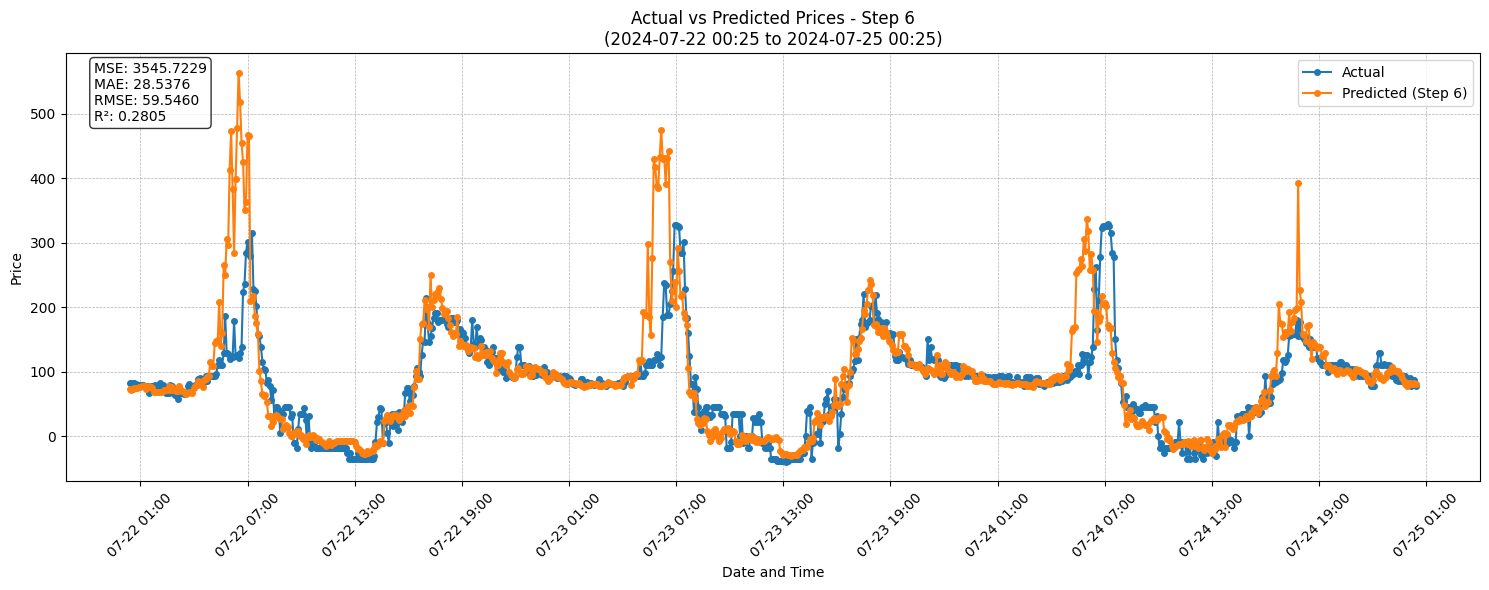

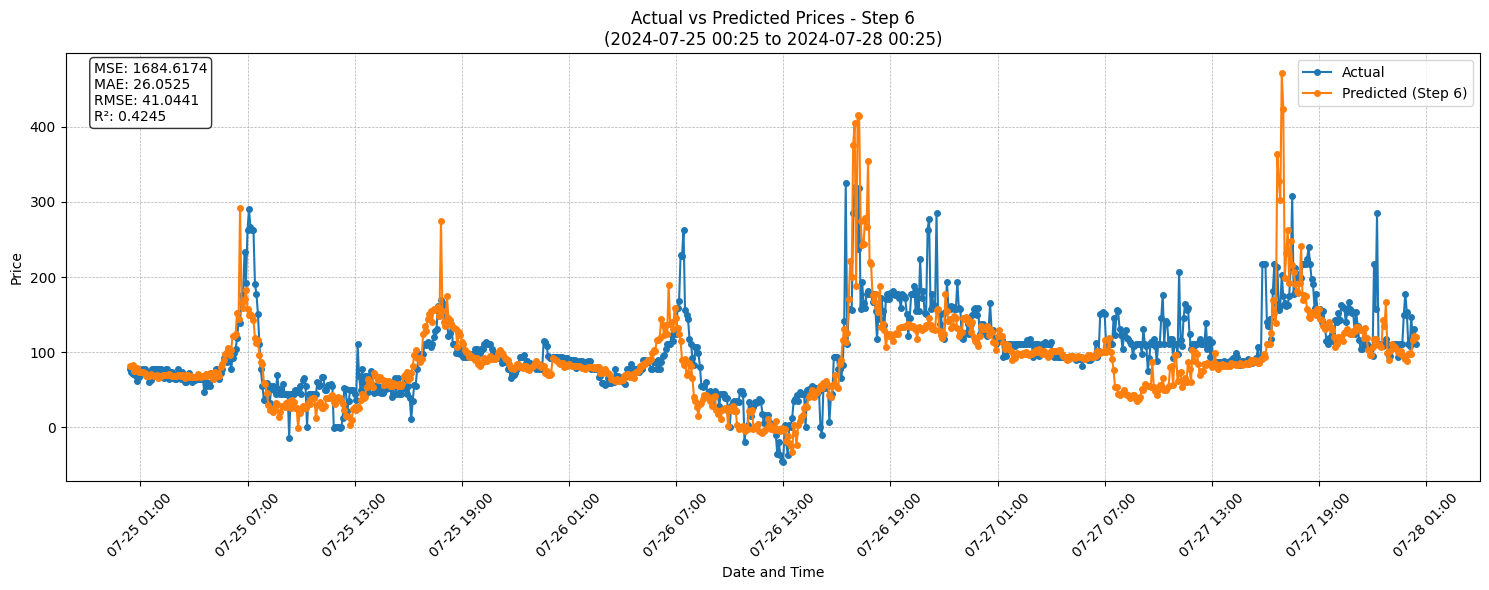

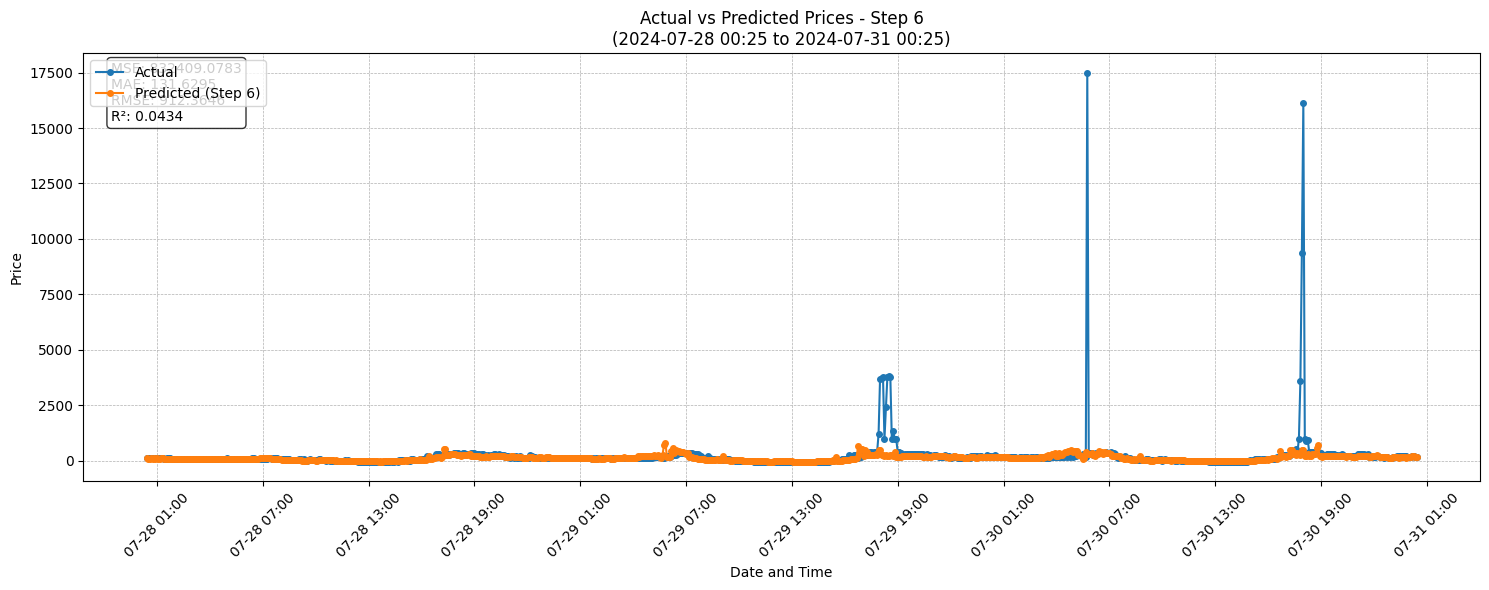

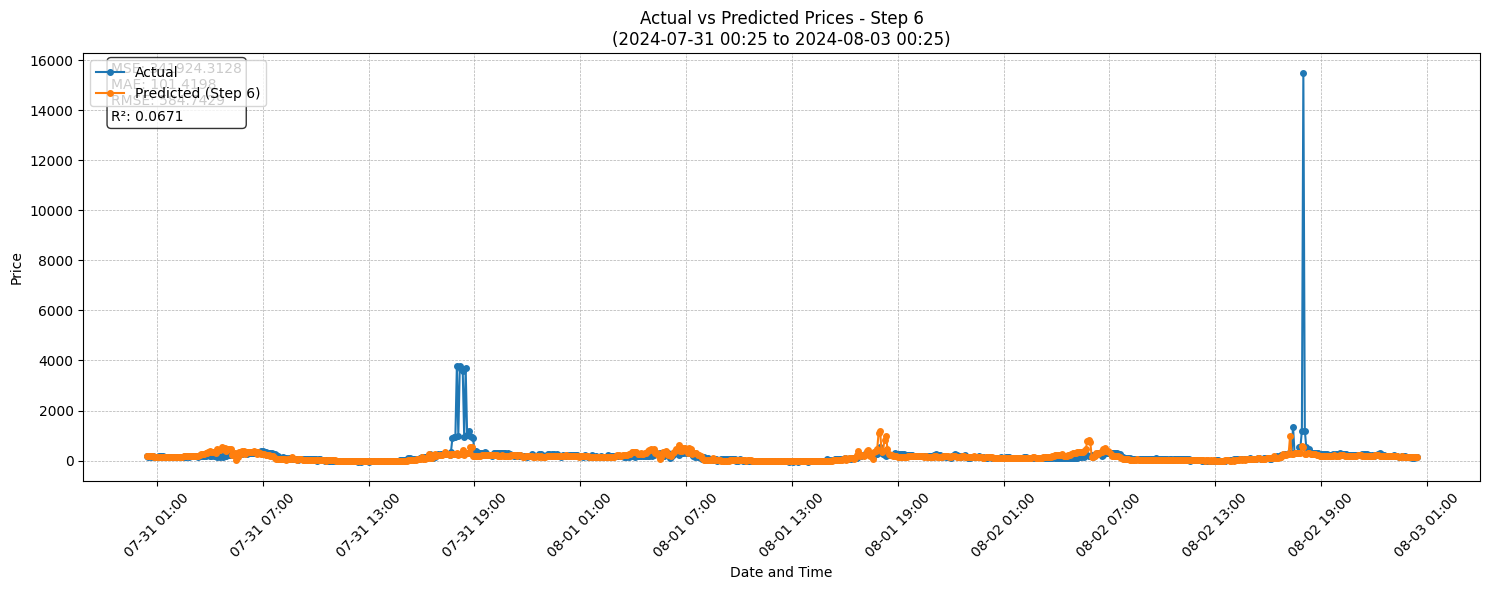

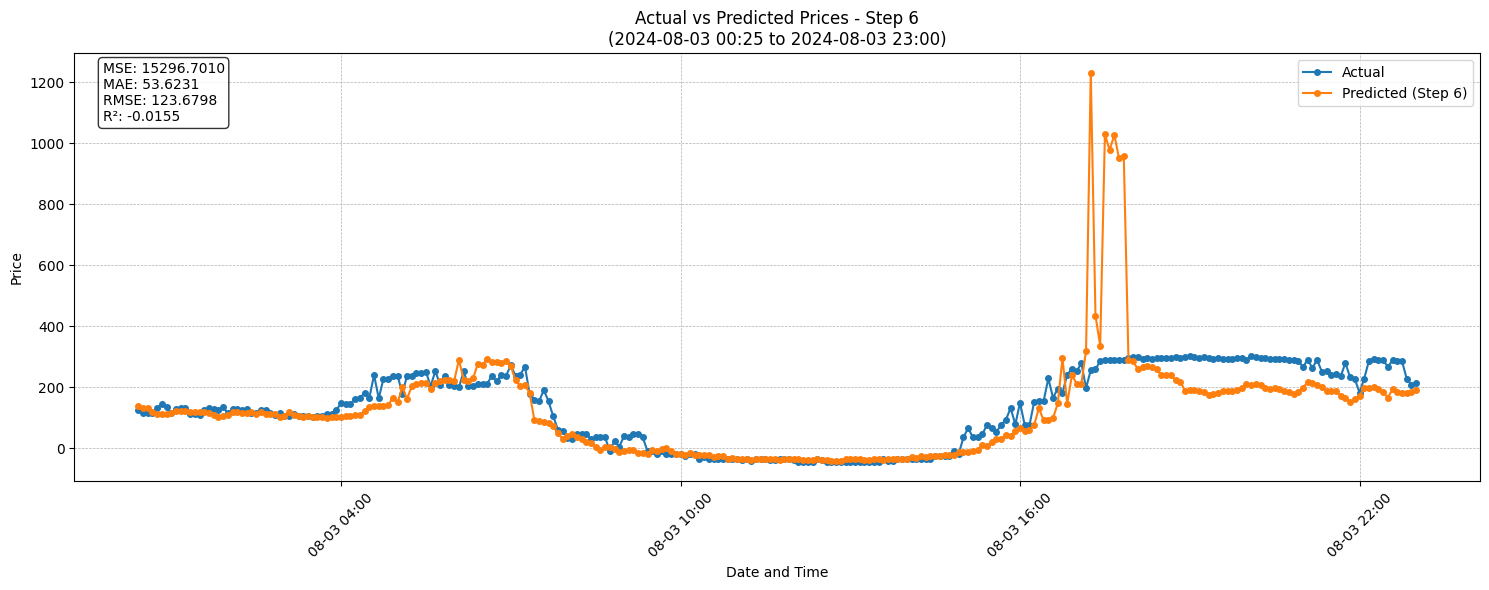

Overall Performance Metrics for Step 12:
Mean Squared Error: 64703.2846
Mean Absolute Error: 53.8635
Root Mean Squared Error: 254.3684
R-squared Score: 0.0450


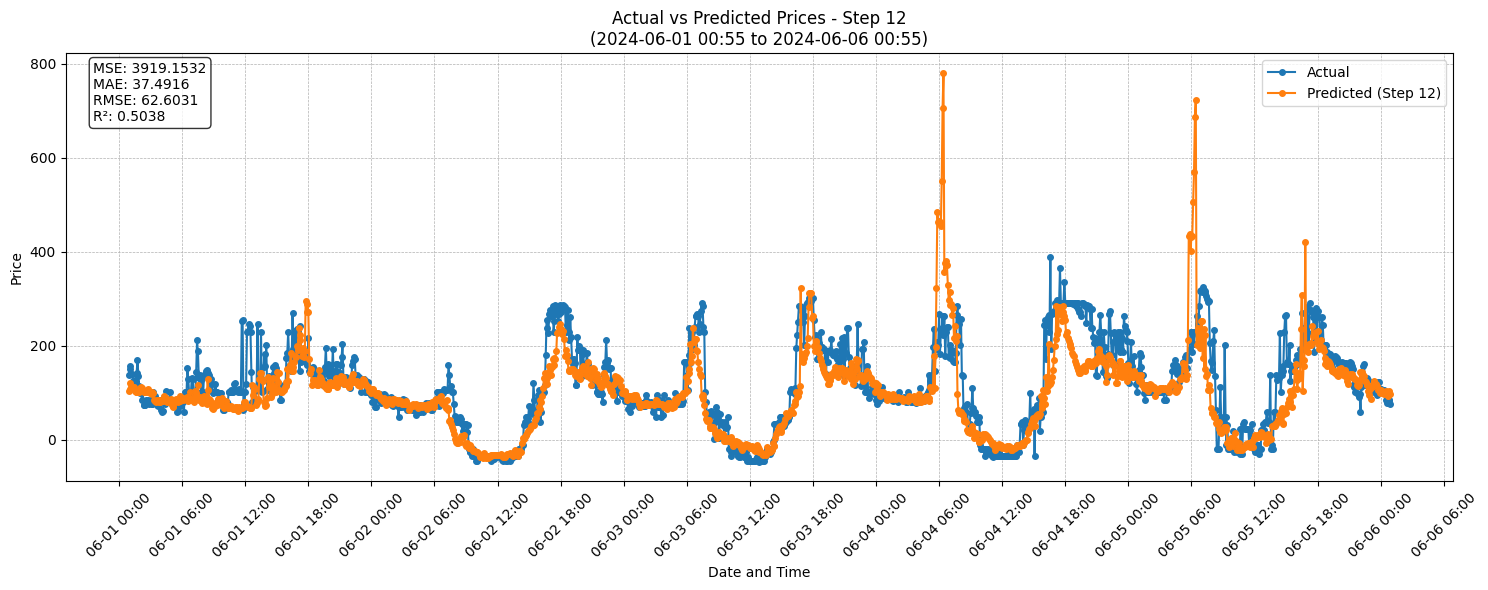

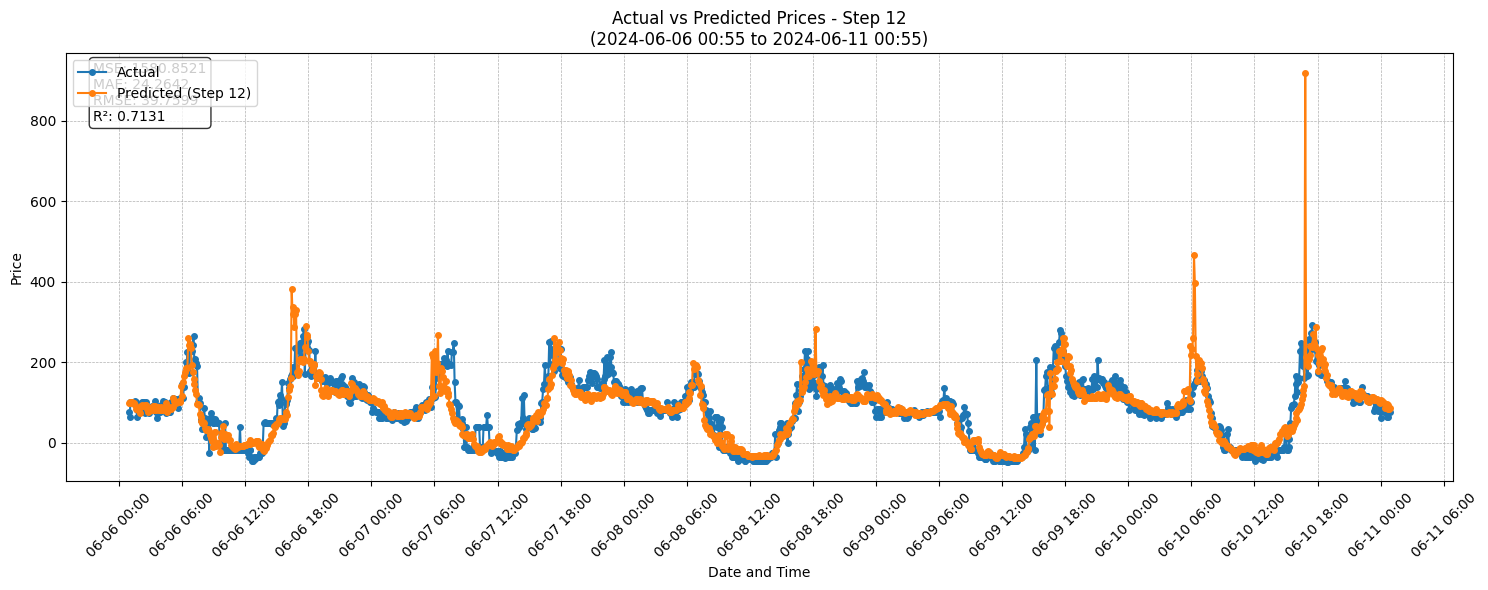

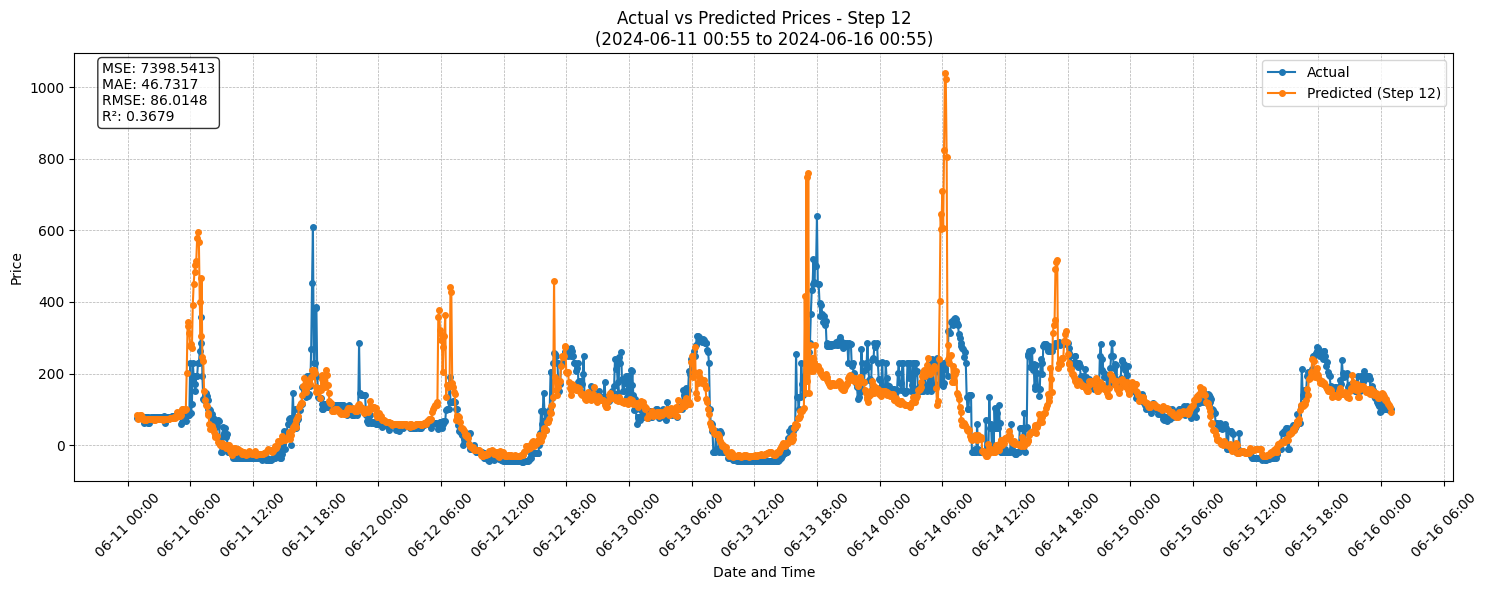

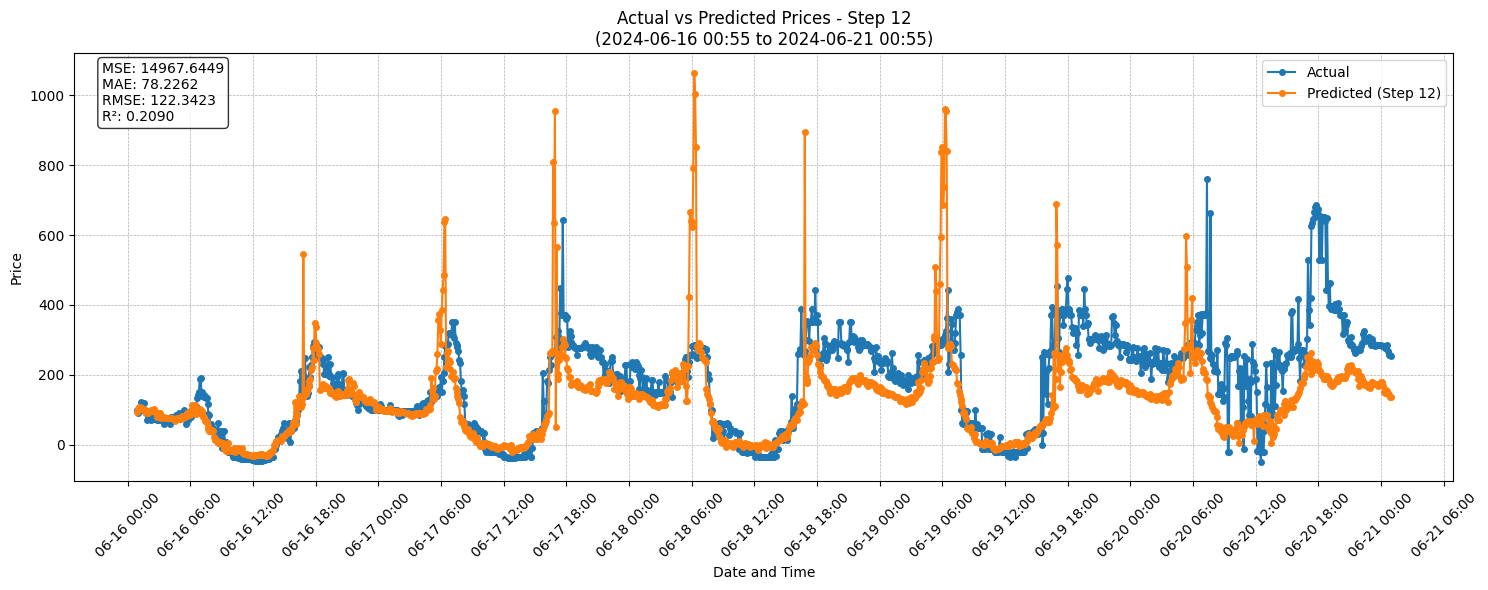

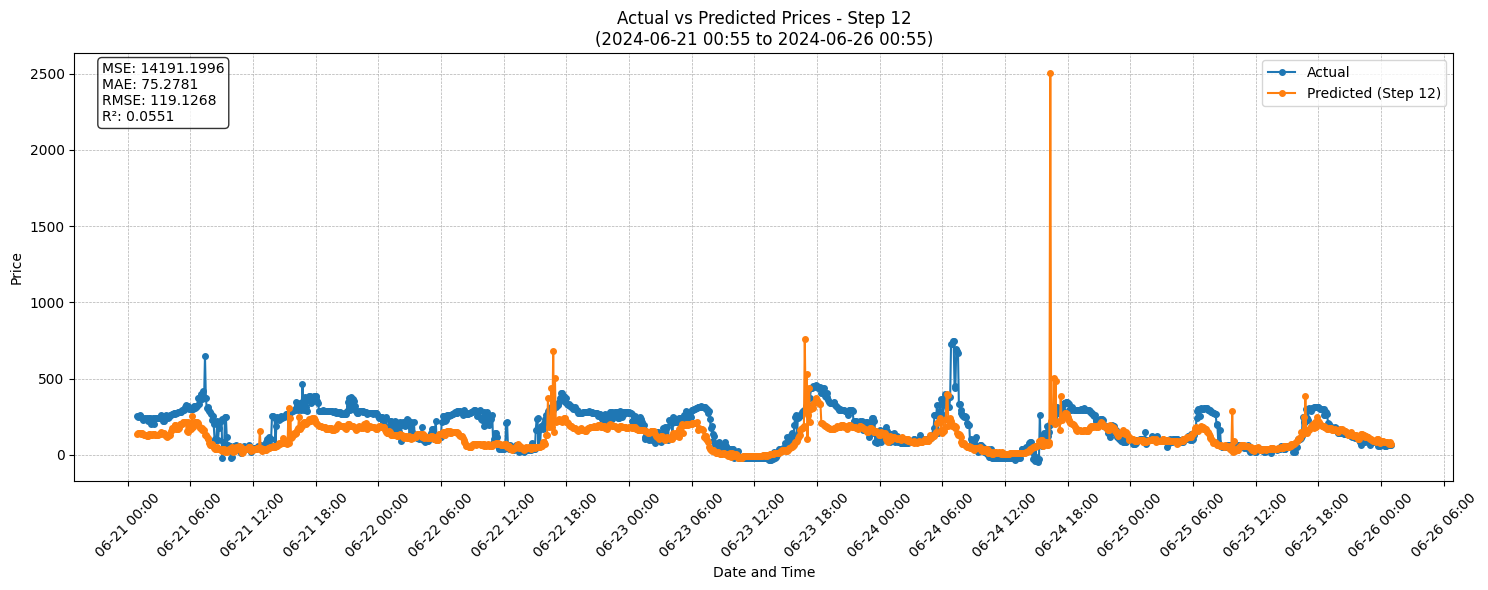

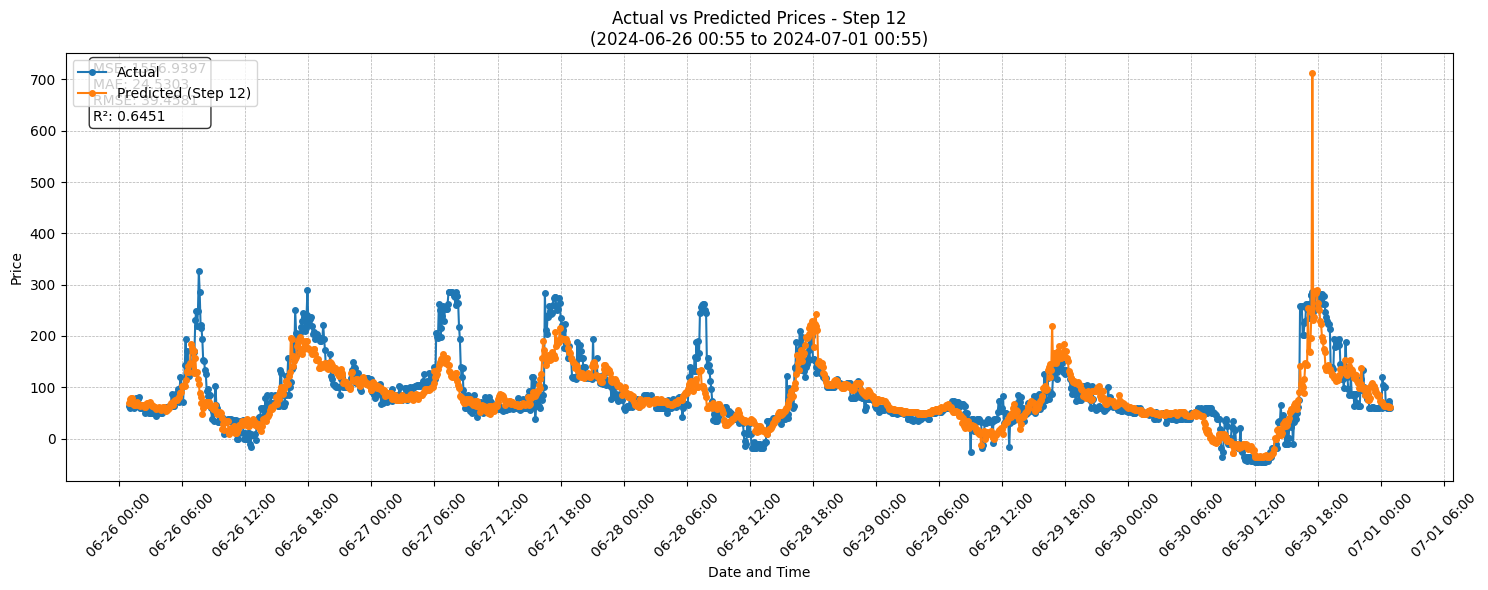

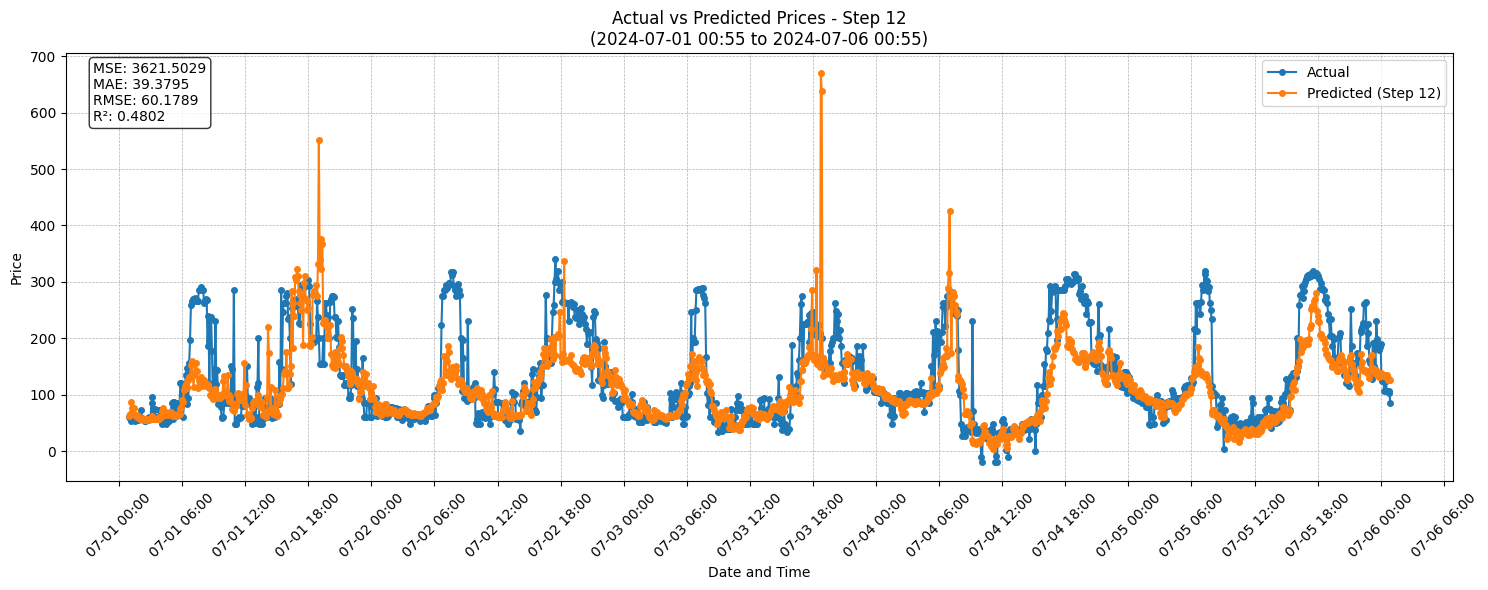

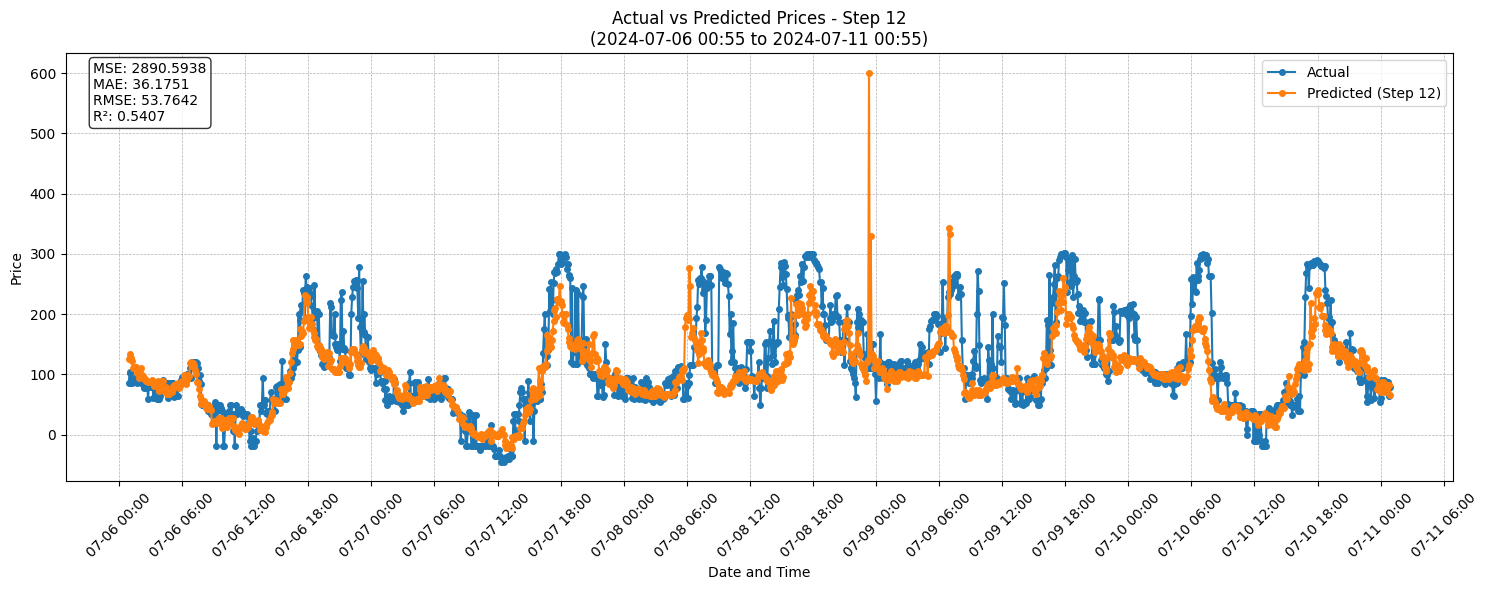

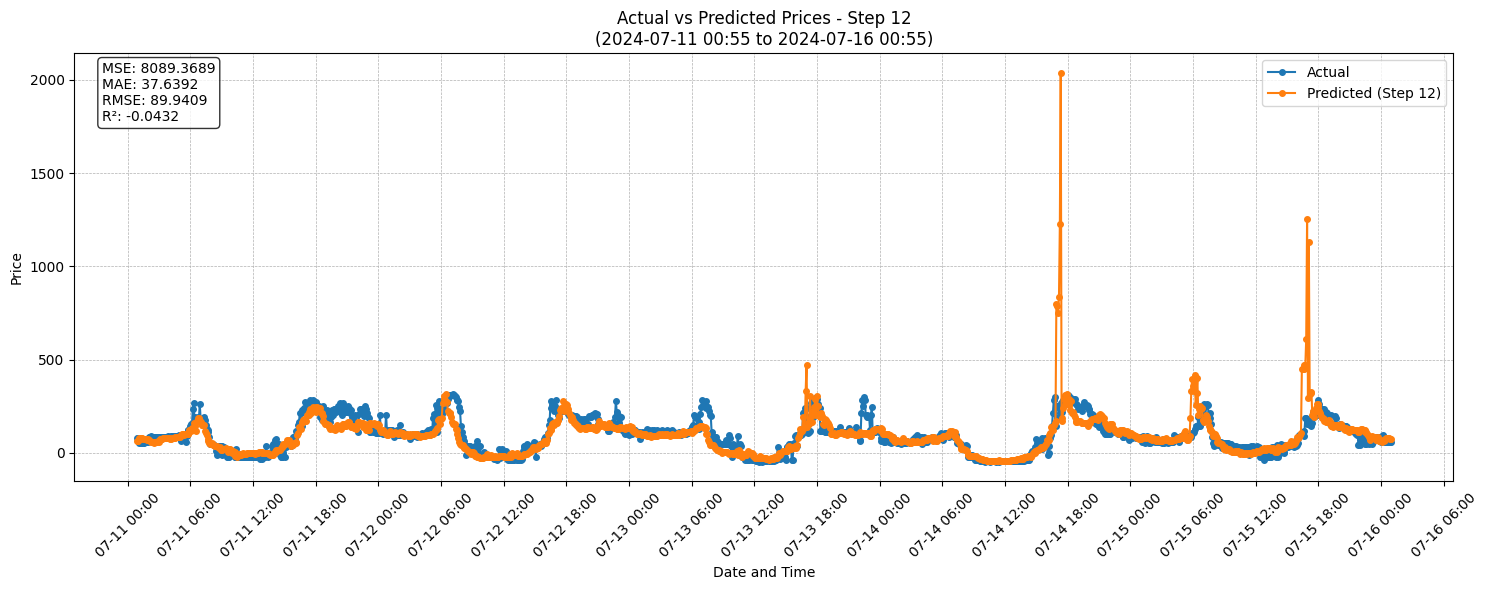

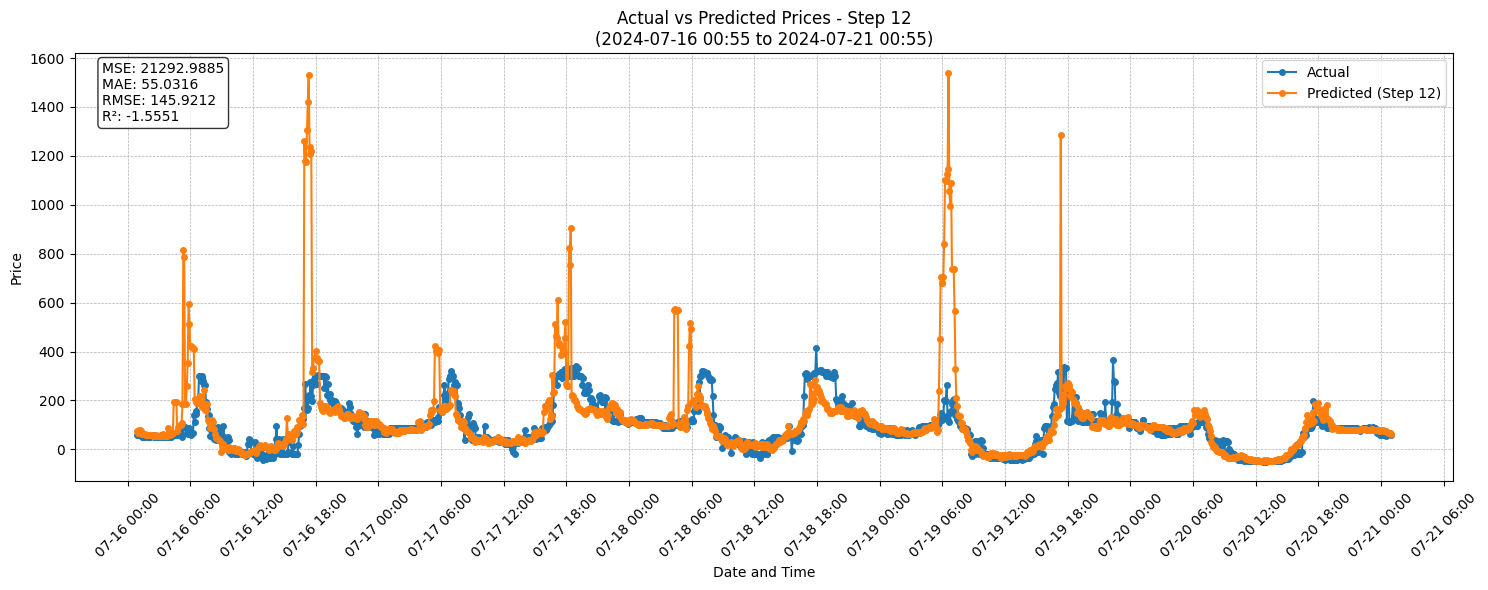

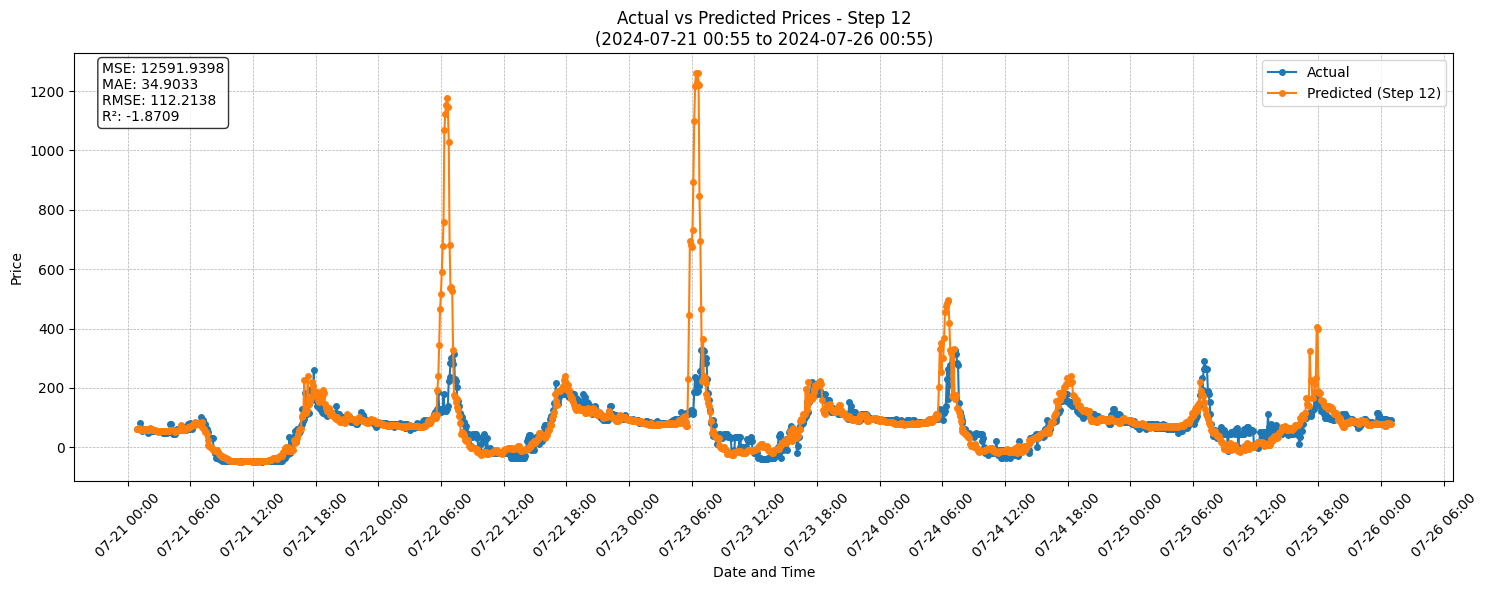

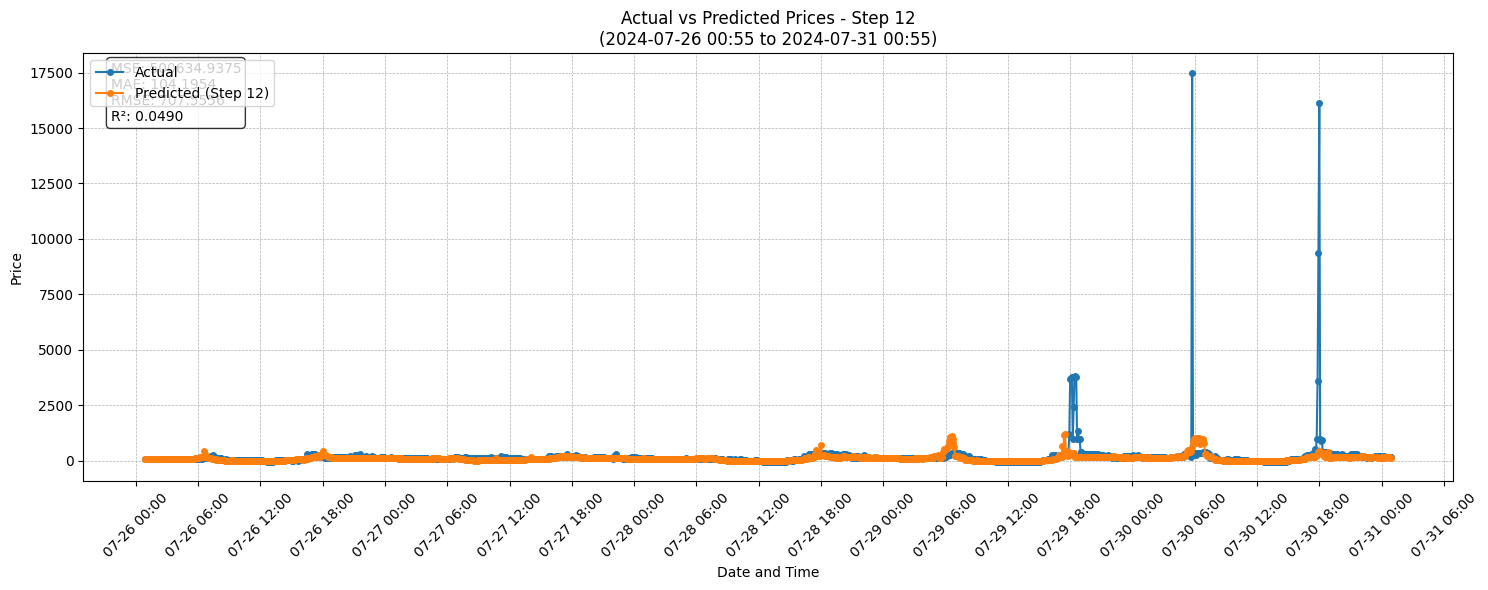

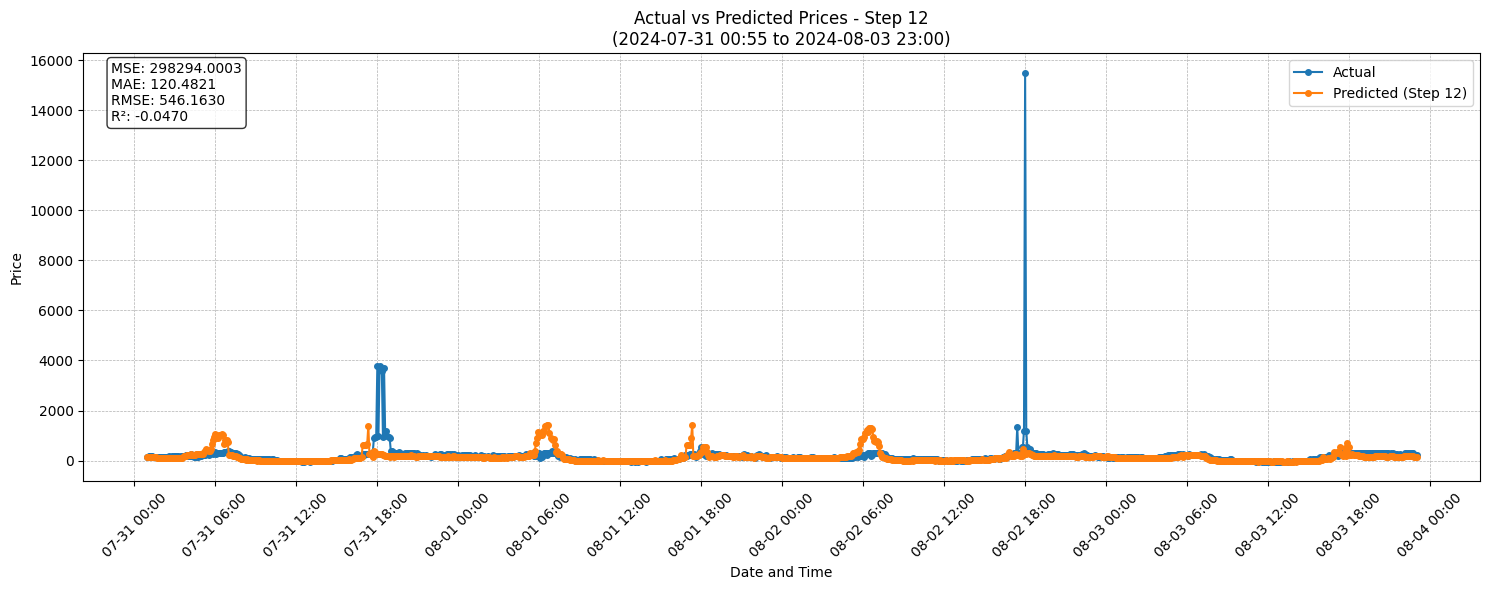

In [13]:
evaluate_and_plot_forecast(y_test, y_pred, step=12)

# To evaluate the 6th step prediction
evaluate_and_plot_forecast(y_test, y_pred, step=6)

# To view 5 days of data at once
evaluate_and_plot_forecast(y_test, y_pred, step=12, days_to_plot=5)

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import HourLocator, DateFormatter
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_and_plot_forecast_extended(y_true, y_pred, steps=[1, 6, 12], days_to_plot=3, success_threshold=0.1):
    """
    Evaluate and plot the results for multiple forecast steps, including success rate statistics
    
    :param y_true: Actual values, pandas Series
    :param y_pred: Predicted values, numpy array with shape (n_samples, n_steps)
    :param steps: List of forecast steps to evaluate, default is [1, 6, 12]
    :param days_to_plot: Number of days to plot in each graph, default is 3
    :param success_threshold: Threshold for considering a prediction successful, default is 0.1 (10%)
    """
    for step in steps:
        if step < 1 or step > y_pred.shape[1]:
            raise ValueError(f"Step {step} should be between 1 and {y_pred.shape[1]}")
        
        # Create results DataFrame
        results_df = pd.DataFrame({
            'Actual': y_true.iloc[step-1:].values,
            'Predicted': y_pred[:-step, step-1]
        }, index=y_true.index[step-1:])
        
        # Calculate overall metrics
        mse = mean_squared_error(results_df['Actual'], results_df['Predicted'])
        mae = mean_absolute_error(results_df['Actual'], results_df['Predicted'])
        rmse = np.sqrt(mse)
        r2 = r2_score(results_df['Actual'], results_df['Predicted'])
        
        print(f"\nOverall Performance Metrics for Step {step}:")
        print(f"Mean Squared Error: {mse:.4f}")
        print(f"Mean Absolute Error: {mae:.4f}")
        print(f"Root Mean Squared Error: {rmse:.4f}")
        print(f"R-squared Score: {r2:.4f}")
        
        # Calculate success rate
        success_rate = calculate_success_rate(results_df, success_threshold)
        print(f"Overall Success Rate: {success_rate:.2%}")
        
        # Calculate success rate for different time periods
        time_periods = [
            ("Morning", "06:00", "12:00"),
            ("Afternoon", "12:00", "18:00"),
            ("Evening", "18:00", "00:00"),
            ("Night", "00:00", "06:00")
        ]
        
        print("\nSuccess Rates by Time Period:")
        for period_name, start_time, end_time in time_periods:
            period_df = results_df.between_time(start_time, end_time)
            period_success_rate = calculate_success_rate(period_df, success_threshold)
            print(f"{period_name}: {period_success_rate:.2%}")
        
        # Plot the results
        start_date = results_df.index.min()
        end_date = results_df.index.max()
        current_date = start_date
        
        while current_date <= end_date:
            period_end = min(current_date + pd.Timedelta(days=days_to_plot), end_date)
            plot_comparison_extended(results_df, current_date, period_end, step, success_threshold)
            current_date += pd.Timedelta(days=days_to_plot)

def calculate_success_rate(data, threshold):
    """
    Calculate the success rate based on the given threshold
    
    :param data: DataFrame containing 'Actual' and 'Predicted' columns
    :param threshold: Threshold for considering a prediction successful
    :return: Success rate as a float between 0 and 1
    """
    relative_error = np.abs(data['Actual'] - data['Predicted']) / data['Actual']
    return (relative_error <= threshold).mean()

def plot_comparison_extended(data, start_date, end_date, step, success_threshold):
    """
    Plot a comparison of actual vs predicted prices for a specific period with extended metrics
    
    :param data: DataFrame containing 'Actual' and 'Predicted' columns
    :param start_date: Start date of the period to plot
    :param end_date: End date of the period to plot
    :param step: Forecast step being evaluated
    :param success_threshold: Threshold for considering a prediction successful
    """
    period_data = data.loc[start_date:end_date]
    
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(period_data.index, period_data['Actual'], label='Actual', marker='o', markersize=4)
    ax.plot(period_data.index, period_data['Predicted'], label=f'Predicted (Step {step})', marker='o', markersize=4)
    
    ax.set_title(f'Actual vs Predicted Prices - Step {step}\n({start_date.strftime("%Y-%m-%d %H:%M")} to {end_date.strftime("%Y-%m-%d %H:%M")})')
    ax.set_xlabel('Date and Time')
    ax.set_ylabel('Price')
    ax.legend()
    
    ax.xaxis.set_major_locator(HourLocator(interval=6))
    ax.xaxis.set_major_formatter(DateFormatter('%m-%d %H:%M'))
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Calculate and display metrics for the current period
    mse = mean_squared_error(period_data['Actual'], period_data['Predicted'])
    mae = mean_absolute_error(period_data['Actual'], period_data['Predicted'])
    rmse = np.sqrt(mse)
    r2 = r2_score(period_data['Actual'], period_data['Predicted'])
    success_rate = calculate_success_rate(period_data, success_threshold)
    
    metrics_text = (f'MSE: {mse:.4f}\nMAE: {mae:.4f}\nRMSE: {rmse:.4f}\n'
                    f'R²: {r2:.4f}\nSuccess Rate: {success_rate:.2%}')
    plt.text(0.02, 0.98, metrics_text, transform=ax.transAxes, verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.show()
evaluate_and_plot_forecast_extended(y_test, y_pred, steps=[1, 6, 12], days_to_plot=3, success_threshold=0.1)

ValueError: Length of values (18420) does not match length of index (385)